In [8]:
from __future__ import annotations

from pathlib import Path
from datetime import date, timedelta
from collections import Counter, defaultdict
import glob
import gc

import polars as pl
import matplotlib.pyplot as plt
import sqlite3
import math
import heapq
import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import polars as pl
from tqdm.auto import tqdm


## What “clusters” (entities) mean

A **cluster / entity** is a **connected component** in a graph:

- **Nodes = addresses**
- **Edges = “same controller” links** inferred from transaction patterns

A **cluster size** is simply: **how many addresses became connected** through these inferred links.

---

## Algorithm overview (step-by-step)

### 0) Define two time windows

Two overlapping windows are used:

- **Index window** `[INDEX_START, ANALYSIS_END)`  
  Build an outpoint index so inputs can be resolved to addresses.
- **Analysis window** `[ANALYSIS_START, ANALYSIS_END)`  
  Apply heuristics and add unions (one year of clustering).

Why this is necessary: **Bitcoin inputs do not contain an address**.  
An input only references a previous output (`prev_txid`, `prev_vout`). The address lives in that previous output.

---

### 1) Build an outpoint index (outputs → address)

For each day/file in the **index window**, take rows with `dir == "out"` and store:

- key: `(txid, n)` where `n` is output index (vout)
- value: `address`

This creates a local map: **(prev_txid, prev_vout) → address**, which allows later recovery of input addresses.

---

### 2) Resolve input addresses (prevouts → address)

For each day/file in the **analysis window**, for every row with `dir == "in"`:

- `spend_txid` = spending transaction id
- `(prev_txid, prev_vout)` = the referenced output being spent

Then:

- count total inputs per spending tx: `input_utxo_count[spend_txid] += 1`
- look up `(prev_txid, prev_vout)` in the outpoint index to obtain the **input address**
- group resolved input addresses per spending tx:  
  `inputs_by_txid[spend_txid] = {addr1, addr2, ...}`

Important:
- `input_utxo_count` counts **all inputs** (even unresolved)
- `inputs_by_txid` contains only **resolved input addresses**

---

### 3) Group outputs per transaction

Still within the analysis window, group `dir == "out"` rows by `txid` and collect:

- `out_addrs: [address, ...]`
- `out_values: [value, ...]`

Now each transaction can be analyzed using:
- input UTXO count,
- resolved input addresses,
- output addresses + output amounts.

---

### 4) Per transaction: apply filters + heuristics → add “same owner” edges

For each transaction `txid` that has outputs and at least one input:

#### 4.1 Skip transactions with insufficient structure
- no outputs → skip
- `input_utxo_count[txid] == 0` → skip

#### 4.2 Skip collaborative patterns (CoinJoin-like)
A simple CoinJoin-ish filter flags a transaction if:
- `n_in_utxos >= 3`
- `n_out >= 3`
- at least 3 outputs share exactly the same amount

If flagged:
- **do not add any unions**
- only mark outputs as “seen” (for later “new output” checks)

Goal: avoid linking unrelated participants.

#### 4.3 Multi-input heuristic (high-signal link)
If `n_in_utxos >= 2`:
- take the **resolved unique input addresses** for this tx
- if there are ≥2 distinct resolved input addresses → connect (union) them all
- if only 1 resolved input address → mark it as participating, but no additional links can be created

Interpretation: spending multiple inputs in one transaction usually requires control over all corresponding private keys (or custody over them), so they are treated as belonging to the same entity.

#### 4.4 Change heuristic (riskier link)
Attempt to identify exactly one output that is likely “change” back to the spender:

Candidate output must satisfy all:
- output address is **not** one of the resolved input addresses (not a self-send)
- output address type matches the **majority input type** (prefix-based: `1...`, `3...`, `bc1...`)
- output address is **new as an output** (has not appeared before as an output)

If *exactly one* candidate remains:
- label it as change
- connect (union) it to an input address (e.g., the first resolved input)

Finally:
- mark all outputs as “seen” to support future “new output” tests.

---

### 5) After scanning all files: compress unions → entity IDs → cluster sizes

After processing the entire analysis window:

1) compute each address’s Union-Find root
2) assign a contiguous `entity_id` per root
3) compute cluster sizes (e.g., via `bincount(entity_id)`)
4) report:
   - largest cluster size and fraction
   - top-K cluster sizes
   - quantiles (median/90th/99th)
   - heuristic coverage (how many nodes were linked by which heuristic)
5) optionally write mapping `(address → entity_id)` to Parquet (ideally in chunks)

---

## How to interpret “less permissive union” results

The typical outcome is **heavy-tailed**:

- many clusters of size 1–10
- fewer clusters of size 10–1000
- very few clusters of size 10k+

Sometimes there is a **giant component** (largest cluster far larger than the rest).  
This can be:
- **plausible**: large custodial/service wallets consolidating many deposits
- **a red flag**: false change links “bridge” unrelated clusters, causing cascade merges

Tightening change inference typically causes:
- fewer unions,
- more fragmentation (more clusters),
- reduced dominance of the largest cluster (if change links were the main bridge source).

If the largest cluster stays huge even with strict change rules, it is often driven by multi-input consolidation patterns of large services, or by collaborative transactions not caught by the filter.

In [9]:
# -----------------------------
# Sanity checks + prevout join sanity
# -----------------------------
from collections import Counter
import math

OUTPUT_DIR_VALUES = {"out", "vout", "output", "o"}
INPUT_DIR_VALUES  = {"in", "vin", "input", "i"}

def run_sanity_checks(
    n_nodes: int,
    node_to_entity: list[int] | np.ndarray | None = None,
    cluster_size_counter: Counter | None = None,
    prevout_lookups: int | None = None,
    prevout_hits: int | None = None,
    top_k: int = 20,
) -> None:
    """
    Prints:
      - largest cluster fraction of nodes
      - top cluster sizes
      - entity count stats
      - optional prevout hit-rate
    Provide either node_to_entity OR cluster_size_counter.
    """
    if cluster_size_counter is None:
        if node_to_entity is None:
            raise ValueError("Provide either node_to_entity or cluster_size_counter.")
        cluster_size_counter = Counter(list(node_to_entity))

    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found (sizes empty).")
        return

    sizes_sorted = sorted(sizes, reverse=True)
    total_nodes_from_sizes = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total_nodes_from_sizes if total_nodes_from_sizes else float("nan")

    print("\n[SANITY] Cluster summary")
    print(f"  UF nodes (n_nodes): {n_nodes:,}")
    print(f"  Total nodes from cluster sizes: {total_nodes_from_sizes:,}")
    if total_nodes_from_sizes != n_nodes:
        print("  [WARN] sum(cluster_sizes) != n_nodes  -> mismatch suggests a bug in mapping logic.")
    print(f"  Entities (clusters): {len(cluster_size_counter):,}")
    print(f"  Largest cluster size: {largest:,}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")

    print(f"\n[SANITY] Top {top_k} cluster sizes:")
    print(" ", sizes_sorted[:top_k])

    # nearest-rank percentile helper
    def pct(p: float) -> int:
        if not sizes_sorted:
            return 0
        s_asc = sorted(sizes_sorted)
        idx = max(0, min(len(s_asc) - 1, math.ceil(p * len(s_asc)) - 1))
        return int(s_asc[idx])

    med = int(sorted(sizes_sorted)[len(sizes_sorted) // 2])
    print("\n[SANITY] Quick distribution stats")
    print(f"  Median cluster size: {med:,}")
    print(f"  90th percentile cluster size: {pct(0.90):,}")
    print(f"  99th percentile cluster size: {pct(0.99):,}")

    if prevout_lookups is not None and prevout_hits is not None:
        rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
        print("\n[SANITY] Prevout lookup hit-rate (DB)")
        print(f"  Lookups:  {prevout_lookups:,}")
        print(f"  Hits:     {prevout_hits:,}")
        print(f"  Hit-rate: {rate:.2%}")


def prevout_join_sanity_polars(one_io_parquet: str) -> None:
    """
    Pure-Polars sanity on a single parquet:
      - prev_vout integer-likeness
      - duplicate outpoints (txid,n)
      - left join vin->vout inside same parquet
      - match explosion check
    Note: This join only resolves prevouts that point to outputs present in this same file.
    Your real pipeline resolves against the outpoint DB across days.
    """
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","n","prev_txid","prev_vout","address","value"])

    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))

    vout = (
        df.filter(pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("out_txid"),
              pl.col("n").cast(pl.Int64, strict=False).alias("out_n"),
              pl.col("address").alias("out_address"),
              pl.col("value").alias("out_value"),
          ])
          .filter(pl.col("out_txid").is_not_null() & pl.col("out_n").is_not_null())
    )

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
          .filter(pl.col("spend_txid").is_not_null() & pl.col("prev_txid").is_not_null())
    )

    print("\n[PREVOUT-SANITY | POLARS]")
    print("File:", one_io_parquet)
    print("Rows:", {"vin": vin.height, "vout": vout.height})

    # 1) Check prev_vout is integer-like (if float-ish in schema)
    vin_nonnull = vin.filter(pl.col("prev_vout").is_not_null())
    if vin_nonnull.height > 0:
        frac_integerlike = (
            vin_nonnull
            .with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
            .select(pl.col("is_intlike").mean())
            .item()
        )
        print(f"prev_vout integer-like fraction: {float(frac_integerlike):.6f}")

    # Cast prev_vout safely to int for joining
    vin2 = vin.with_columns(
        pl.when(pl.col("prev_vout").is_not_null())
          .then(pl.col("prev_vout").cast(pl.Int64, strict=False))
          .otherwise(None)
          .alias("prev_vout_i64")
    )

    # 2) Check uniqueness of outpoints
    dupe_outpoints = (
        vout.group_by(["out_txid","out_n"])
            .len()
            .filter(pl.col("len") > 1)
            .height
    )
    print("Duplicate outpoints (should be 0):", dupe_outpoints)

    # 3) Join vin prevouts -> vout outpoints (within same file)
    joined = (
        vin2.join(
            vout,
            left_on=["prev_txid","prev_vout_i64"],
            right_on=["out_txid","out_n"],
            how="left",
        )
    )

    resolved = joined.filter(pl.col("out_address").is_not_null()).height
    lookups  = vin.height
    print(f"Prevout resolution hit-rate (within-file): {resolved}/{lookups} = {resolved/lookups:.2%}" if lookups else "No vin rows")

    # 4) Check for join explosion: each input should match <= 1 output
    if joined.height > 0:
        max_matches_per_input = (
            joined.group_by(["spend_txid","prev_txid","prev_vout_i64"])
                  .len()
                  .select(pl.col("len").max())
                  .item()
        )
        print("Max matches per (spend_txid, prev_txid, prev_vout):", int(max_matches_per_input) if max_matches_per_input is not None else None)

    sample_unresolved = (
        joined.filter(pl.col("out_address").is_null())
              .select(["spend_txid","prev_txid","prev_vout_i64"])
              .head(5)
    )
    print("\nSample unresolved inputs (within-file):")
    print(sample_unresolved)


def prevout_join_sanity_db(conn: sqlite3.Connection, one_io_parquet: str, sample_limit: int = 200_000) -> None:
    """
    Sanity-check using your ACTUAL outpoint DB resolution:
      - reads vin from a single parquet
      - casts prev_vout -> int64
      - looks up in DB using your lookup_outpoints_hybrid
      - prints DB hit-rate and sample unresolved keys
    Uses only a sample of inputs (sample_limit) to keep it cheap.
    """
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","prev_txid","prev_vout"])
    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
          .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
          .head(sample_limit)
    )

    print("\n[PREVOUT-SANITY | DB]")
    print("File:", one_io_parquet)
    print("Vin sample rows:", vin.height)

    if vin.height == 0:
        print("No vin rows in sample.")
        return

    # integer-likeness check
    frac_integerlike = (
        vin.with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
           .select(pl.col("is_intlike").mean())
           .item()
    )
    print(f"prev_vout integer-like fraction (sample): {float(frac_integerlike):.6f}")

    vin2 = vin.with_columns(
        pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_vout_i64")
    ).filter(pl.col("prev_vout_i64").is_not_null())

    keys = [
        (prev_txid, int(prev_n))
        for prev_txid, prev_n in vin2.select(["prev_txid", "prev_vout_i64"]).iter_rows(named=False, buffer_size=200_000)
    ]
    if not keys:
        print("No usable keys after casting prev_vout.")
        return

    hits = lookup_outpoints_hybrid(conn, keys)
    resolved = len(hits)
    lookups = len(keys)

    print(f"DB prevout hit-rate (sample): {resolved}/{lookups} = {resolved/lookups:.2%}")

    # show unresolved examples
    unresolved = []
    for k in keys[:5000]:
        if k not in hits:
            unresolved.append(k)
            if len(unresolved) >= 10:
                break
    if unresolved:
        print("Sample unresolved (prev_txid, prev_n):")
        for k in unresolved:
            print(" ", k)
    else:
        print("No unresolved keys in first 5000 keys (good sign).")


Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2012-01-02 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[INFO] Outpoint DB: /media/vatereal/Main/outputs/outpoints_2013.sqlite (reset=True)
[INFO] Eligible files in window: 753  (preload=375, analysis=378)
[INFO] Sanity parquet selected: /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet


Processing parquet:   0%|          | 0/753 [00:00<?, ?file/s]

[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-02/io-000160190-000160340.parquet (day=2012-01-02) ...
[INFO] Detected value unit: btc  (all internal amount logic uses satoshis)
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-03/io-000160341-000160499.parquet (day=2012-01-03) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-04/io-000160500-000160648.parquet (day=2012-01-04) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[2] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[3] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[4] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000215033-000215039.parquet (day=2013-01-03) ...
[5] Processing /media/vatereal/Main/parquet/io/day=2013-01-04/io-00

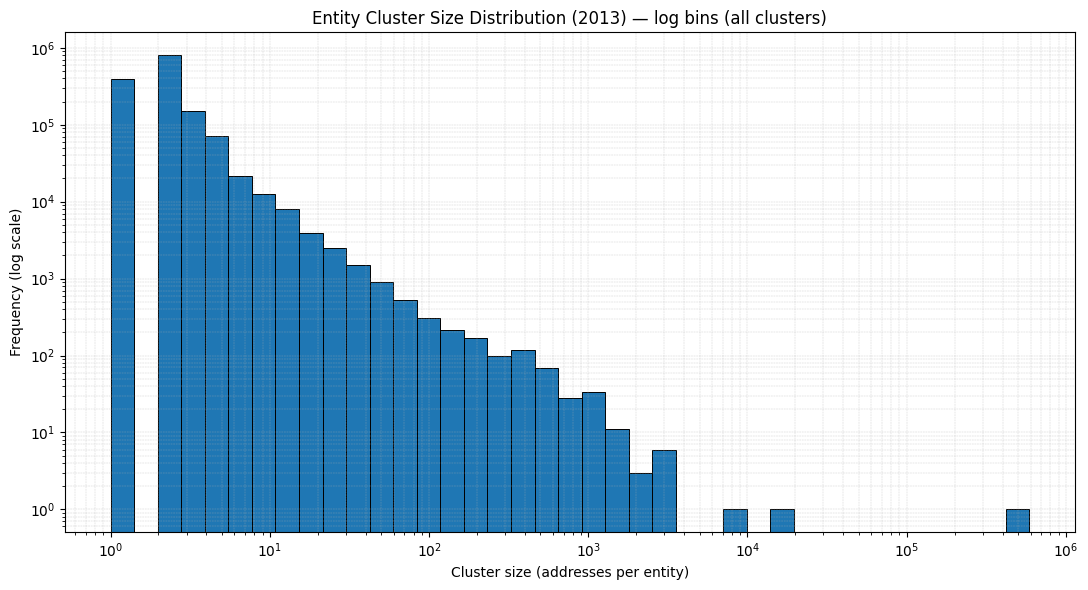

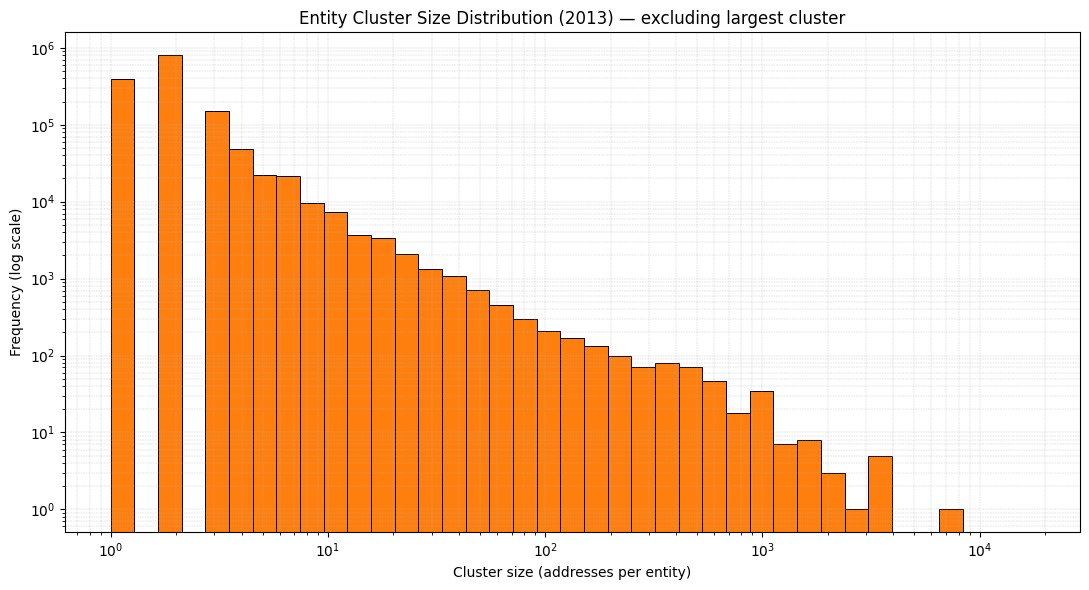

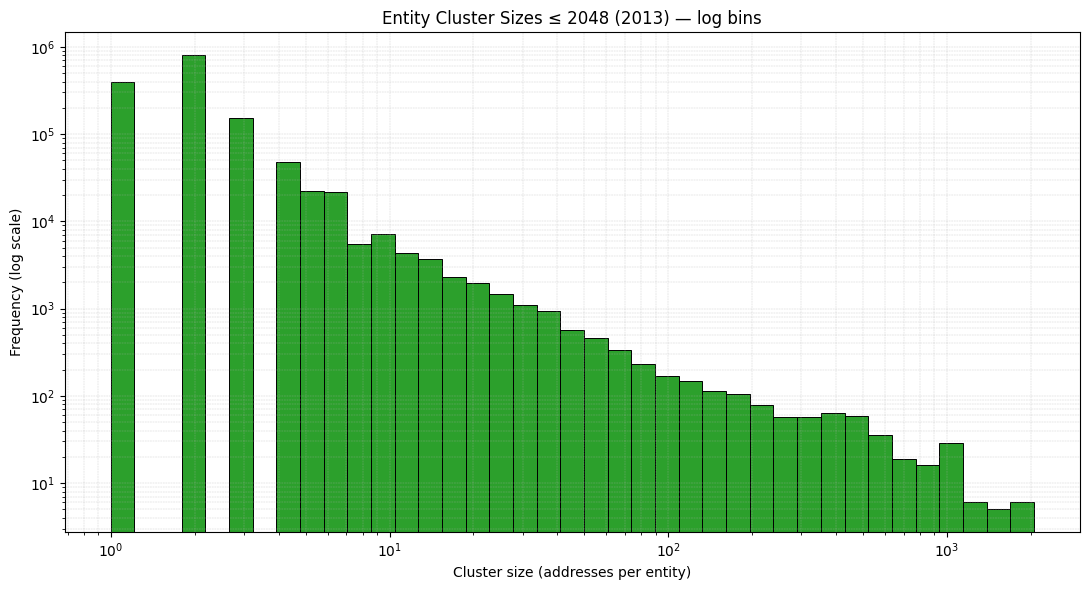

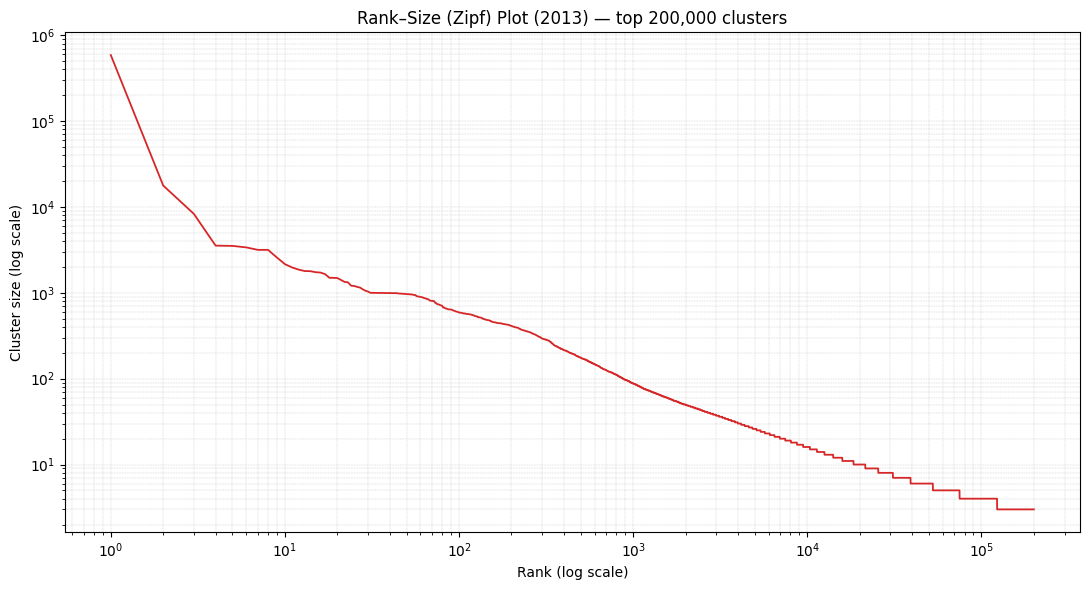

[INFO] Done.


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations

import gc
import glob
import math
import sqlite3
from collections import Counter, defaultdict
from datetime import date, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.auto import tqdm


# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "io": str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

io_paths = sorted(glob.glob(patterns["io"]))
print("Parquet file counts:", {"io": len(io_paths)})

# -----------------------------
# Analysis window: single year
# -----------------------------
ANALYSIS_YEAR = 2013
ANALYSIS_START = date(ANALYSIS_YEAR, 1, 1)
ANALYSIS_END = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive
print(f"[INFO] Analysis window: {ANALYSIS_START} .. {ANALYSIS_END} (exclusive)")

# OPTIONAL: preload outputs before year start so early-year spends resolve.
OUTPOINT_DB_LOOKBACK_DAYS = 365
INDEX_START = ANALYSIS_START - timedelta(days=OUTPOINT_DB_LOOKBACK_DAYS)
print(f"[INFO] Outpoint DB preload start: {INDEX_START} .. {ANALYSIS_END} (exclusive)")

# Whether to create UF nodes for every output address (creates huge singleton universe).
PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS = False

# SQLite outpoint index
OUTPOINT_DB_PATH = OUTPUT_DIR / f"outpoints_{ANALYSIS_YEAR}.sqlite"
RESET_OUTPOINT_DB = True  # set False to reuse DB

# Output mapping file (address -> entity_id)
WRITE_ENTITY_MAPPING = True
ENTITY_MAP_OUT_PATH = OUTPUT_DIR / f"entities_multiinput_change_{ANALYSIS_YEAR}.parquet"
ENTITY_MAP_COMPRESSION = "zstd"
ENTITY_WRITE_BATCH = 1_000_000

# Plot controls
ZIPF_TOP_K = 200_000
FOCUS_MAX_SIZE = 2048
LOG_BINS = 40

# Print controls
TOP_K_CLUSTERS = 20

# -----------------------------
# Heuristic toggles (for A/B tests)
# -----------------------------
# A/B test examples:
#   - multi-input only: ENABLE_MULTI_INPUT=True,  ENABLE_CHANGE=False
#   - change only:      ENABLE_MULTI_INPUT=False, ENABLE_CHANGE=True
#   - both:             True/True
ENABLE_COINJOIN_FILTER = True
ENABLE_MULTI_INPUT = True
ENABLE_CHANGE = True
ENABLE_MERGE_GUARDS = True

# Multi-input policy (improvement #1)
#   "one_output": apply H1 only when spendable outputs == 1
#   "one_or_two_nonmix": allow 2-output txs if NOT mixing-like (still riskier)
MULTI_INPUT_POLICY = "one_output"  # default safest

# Change heuristic: keep strict (improvement #3)
CHANGE_REQUIRE_2_OUTPUTS = True  # keep True for high-precision pass

# -----------------------------
# Conservative transaction / fee controls
# -----------------------------
DUST_SATS = 546

MAX_FEE_ABS_SATS = 50_000_000
MAX_FEE_FRAC = 0.05

MAX_CHANGE_INPUTS_UTXOS = 10
MAX_CHANGE_SPENDABLE_OUTS = 2  # tightened: only 2-output spendable by default (improvement #3)

# "Optimal change" constraint (improvement #3)
# change_val should not exceed (min_input - fee) by much; otherwise the smallest input was unnecessary.
ENABLE_OPTIMAL_CHANGE_CONSTRAINT = True
OPTIMAL_CHANGE_SLACK_SATS = 0  # set >0 if you want to allow small slack (e.g., 1000)

# -----------------------------
# Merge guards (improvement #4)
# -----------------------------
# Absolute cap on merge-resulting component size (prevents mega-collapse)
MAX_MERGED_COMPONENT_SIZE = 1_500_000  # tune; if too small you will under-cluster large services
# Ratio guard: prevent a very large cluster from repeatedly absorbing tiny clusters through noisy edges
MERGE_RATIO_GUARD = True
MERGE_RATIO_MAX = 200  # max(size_big/size_small) allowed for "big merges"
MERGE_RATIO_BIG_CLUSTER_MIN = 50_000  # apply ratio guard only if the bigger cluster is at least this size

# Optional: require repeated evidence for LARGE CHANGE merges (cheap “multi-evidence”)
ENABLE_CHANGE_MERGE_VOTES = True
CHANGE_VOTE_SUM_THRESHOLD = 200_000   # if size(A)+size(B) >= threshold, require votes
CHANGE_VOTES_REQUIRED = 2             # require >=2 independent txs to do that big merge

# -----------------------------
# Performance knobs (patched)
# -----------------------------
OUTPOINT_COMMIT_EVERY_ROWS = 500_000

PREVOUT_HYBRID_THRESHOLD = 5_000
PREVOUT_LOOKUP_CHUNK = 50_000

ITER_BUFFER_IN = 200_000
ITER_BUFFER_OUT = 200_000
ITER_BUFFER_GROUPED = 50_000

GC_EVERY_N_FILES = 100

TQDM_MININTERVAL = 2.0
TQDM_MINITERS = 50
TQDM_POSTFIX_EVERY = 250

# -----------------------------
# Sanity knobs
# -----------------------------
RUN_SANITY_CHECKS = True

RUN_PREVOUT_POLARS_SANITY = False  # quick but only within-file
RUN_PREVOUT_DB_SANITY = True       # meaningful: uses the outpoint DB
PREVOUT_SANITY_SAMPLE_LIMIT = 200_000

PREVOUT_SANITY_PARQUET: str | None = None


# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    """
    Union-Find with:
      - union by rank
      - path compression
      - component sizes (for merge guards)
    """
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []
        self.size: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        self.size.append(1)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def comp_size(self, x: int) -> int:
        return self.size[self.find(x)]

    def union_roots(self, rx: int, ry: int) -> int:
        """Union already-found roots; return new root."""
        if rx == ry:
            return rx
        parent = self.parent
        rank = self.rank
        size = self.size

        if rank[rx] < rank[ry]:
            parent[rx] = ry
            size[ry] += size[rx]
            return ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
            size[rx] += size[ry]
            return rx
        else:
            parent[ry] = rx
            rank[rx] += 1
            size[rx] += size[ry]
            return rx

    def union(self, x: int, y: int) -> int:
        rx = self.find(x)
        ry = self.find(y)
        return self.union_roots(rx, ry)


def addr_type(addr: str) -> str:
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def _count_dupe_values(values: list[int], dust_sats: int) -> tuple[int, int]:
    """
    Returns:
      - max duplicate count among values >= dust
      - number of distinct values >= dust
    """
    if not values:
        return 0, 0
    vals = [v for v in values if v >= dust_sats]
    if not vals:
        return 0, 0
    cnt = Counter(vals)
    return max(cnt.values()), len(cnt)


def detect_mixing_like(
    n_in_utxos: int,
    spendable_outs: list[tuple[str, int]],
    dust_sats: int = DUST_SATS,
) -> bool:
    """
    Cheap but stronger CoinJoin/shared-send detection (improvement #2).
    Designed to reduce false positives in H1 (multi-input) and change.
    """
    n_out = len(spendable_outs)
    if n_in_utxos < 3 or n_out < 3:
        return False

    out_vals = [v for (_a, v) in spendable_outs]
    out_types = [addr_type(a) for (a, _v) in spendable_outs if a is not None]
    unique_vals = len(set(out_vals))
    unique_types = len(set(out_types)) if out_types else 0

    max_dupe, distinct_vals_non_dust = _count_dupe_values(out_vals, dust_sats)

    # Signal A: multiple equal-sized outputs (common in CoinJoin)
    # Your old rule required >=3; relax to >=2 for sensitivity.
    if max_dupe >= 2 and distinct_vals_non_dust >= 2:
        return True

    # Signal B: n_in ≈ n_out (typical CoinJoin shape)
    if abs(n_in_utxos - n_out) <= 1 and min(n_in_utxos, n_out) >= 3:
        return True

    # Signal C: low unique value ratio with enough outputs
    # (many repeated values even if not all identical)
    if n_out >= 4:
        if unique_vals <= (n_out // 2):
            return True

    # Signal D: homogeneous script types + many outputs + repeated values
    if n_out >= 4 and unique_types == 1 and max_dupe >= 2:
        return True

    return False


def multi_input_is_safe(
    n_in_utxos: int,
    spendable_outs: list[tuple[str, int]],
    is_mixing_like: bool,
) -> bool:
    """
    Multi-input policy (improvement #1).
    """
    if n_in_utxos < 2:
        return False
    n_out = len(spendable_outs)

    if MULTI_INPUT_POLICY == "one_output":
        return n_out == 1

    if MULTI_INPUT_POLICY == "one_or_two_nonmix":
        if n_out == 1:
            return True
        if n_out == 2 and not is_mixing_like:
            return True
        return False

    raise ValueError(f"Unknown MULTI_INPUT_POLICY={MULTI_INPUT_POLICY}")


# -----------------------------
# Value normalization: detect BTC vs sats and convert to sats
# -----------------------------
VALUE_UNIT: str | None = None  # "btc" or "sats"


def infer_value_unit_from_sample(sample_vals: list[float]) -> str:
    if not sample_vals:
        return "btc"
    mx = max(sample_vals)
    return "sats" if mx >= 1e6 else "btc"


def value_expr_to_sats() -> pl.Expr:
    if VALUE_UNIT == "sats":
        return pl.col("value").cast(pl.Float64, strict=False).round(0).cast(pl.Int64, strict=False)
    return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)


# -----------------------------
# SQLite outpoint DB (stores address + value_sats)
# -----------------------------
def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")  # ~2GB cache (negative => KB)
    cur.execute("PRAGMA wal_autocheckpoint=5000;")

    conn.isolation_level = None

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            value_sats INTEGER NOT NULL,
            PRIMARY KEY(txid, n)
        ) WITHOUT ROWID;
        """
    )
    return conn


def init_lookup_tables(conn: sqlite3.Connection) -> None:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS keybuf;")
    cur.execute(
        """
        CREATE TEMP TABLE keybuf (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL
        );
        """
    )


def insert_outpoints_no_commit(conn: sqlite3.Connection, rows: list[tuple[str, int, str, int]]) -> None:
    if not rows:
        return
    conn.executemany(
        "INSERT OR IGNORE INTO outpoints(txid, n, address, value_sats) VALUES (?, ?, ?, ?);",
        rows,
    )


def lookup_outpoints_or(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = 500,
) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]
        cur.execute(f"SELECT txid, n, address, value_sats FROM outpoints WHERE {where};", params)
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_join(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = PREVOUT_LOOKUP_CHUNK,
) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))

    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]

        cur.execute("DELETE FROM keybuf;")
        cur.executemany("INSERT INTO keybuf(txid, n) VALUES (?, ?);", chunk)

        cur.execute(
            """
            SELECT k.txid, k.n, o.address, o.value_sats
            FROM keybuf k
            JOIN outpoints o
              ON o.txid = k.txid AND o.n = k.n;
            """
        )
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_hybrid(conn: sqlite3.Connection, keys: list[tuple[str, int]]) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    if len(keys) < PREVOUT_HYBRID_THRESHOLD:
        return lookup_outpoints_or(conn, keys, chunk_size=500)
    return lookup_outpoints_join(conn, keys, chunk_size=PREVOUT_LOOKUP_CHUNK)


# -----------------------------
# Plot helpers
# -----------------------------
def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)


def plot_hist_logbins(
    sizes: np.ndarray,
    title: str,
    color: str,
    bins: int = LOG_BINS,
    max_x: int | None = None,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    if max_x is None:
        max_x = int(sizes.max())

    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(
        sizes,
        bins=b,
        log=True,
        color=color,
        edgecolor="black",
        linewidth=0.7,
    )
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_zipf(
    sizes: np.ndarray,
    title: str,
    color: str,
    top_k: int = ZIPF_TOP_K,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    top_k = min(top_k, sizes.size)
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# -----------------------------
# Sanity checks
# -----------------------------
OUTPUT_DIR_VALUES = {"out", "vout", "output", "o"}
INPUT_DIR_VALUES  = {"in", "vin", "input", "i"}


def run_sanity_checks(
    n_nodes: int,
    node_to_entity: list[int] | np.ndarray | None = None,
    cluster_size_counter: Counter | None = None,
    prevout_lookups: int | None = None,
    prevout_hits: int | None = None,
    top_k: int = 20,
) -> None:
    if cluster_size_counter is None:
        if node_to_entity is None:
            raise ValueError("Provide either node_to_entity or cluster_size_counter.")
        cluster_size_counter = Counter(list(node_to_entity))

    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found (sizes empty).")
        return

    sizes_sorted = sorted(sizes, reverse=True)
    total_nodes_from_sizes = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total_nodes_from_sizes if total_nodes_from_sizes else float("nan")

    print("\n[SANITY] Cluster summary")
    print(f"  UF nodes (n_nodes): {n_nodes:,}")
    print(f"  Total nodes from cluster sizes: {total_nodes_from_sizes:,}")
    if total_nodes_from_sizes != n_nodes:
        print("  [WARN] sum(cluster_sizes) != n_nodes  -> mismatch suggests a bug in mapping logic.")
    print(f"  Entities (clusters): {len(cluster_size_counter):,}")
    print(f"  Largest cluster size: {largest:,}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")

    print(f"\n[SANITY] Top {top_k} cluster sizes:")
    print(" ", sizes_sorted[:top_k])

    def pct(p: float) -> int:
        if not sizes_sorted:
            return 0
        s_asc = sorted(sizes_sorted)
        idx = max(0, min(len(s_asc) - 1, math.ceil(p * len(s_asc)) - 1))
        return int(s_asc[idx])

    med = int(sorted(sizes_sorted)[len(sizes_sorted) // 2])
    print("\n[SANITY] Quick distribution stats")
    print(f"  Median cluster size: {med:,}")
    print(f"  90th percentile cluster size: {pct(0.90):,}")
    print(f"  99th percentile cluster size: {pct(0.99):,}")

    if prevout_lookups is not None and prevout_hits is not None:
        rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
        print("\n[SANITY] Prevout lookup hit-rate (DB)")
        print(f"  Lookups:  {prevout_lookups:,}")
        print(f"  Hits:     {prevout_hits:,}")
        print(f"  Hit-rate: {rate:.2%}")


def prevout_join_sanity_db(conn: sqlite3.Connection, one_io_parquet: str, sample_limit: int = 200_000) -> None:
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","prev_txid","prev_vout"])
    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
          .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
          .head(sample_limit)
    )

    print("\n[PREVOUT-SANITY | DB]")
    print("File:", one_io_parquet)
    print("Vin sample rows:", vin.height)

    if vin.height == 0:
        print("No vin rows in sample.")
        return

    frac_integerlike = (
        vin.with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
           .select(pl.col("is_intlike").mean())
           .item()
    )
    print(f"prev_vout integer-like fraction (sample): {float(frac_integerlike):.6f}")

    vin2 = vin.with_columns(
        pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_vout_i64")
    ).filter(pl.col("prev_vout_i64").is_not_null())

    keys = [
        (prev_txid, int(prev_n))
        for prev_txid, prev_n in vin2.select(["prev_txid", "prev_vout_i64"]).iter_rows(named=False, buffer_size=200_000)
    ]
    if not keys:
        print("No usable keys after casting prev_vout.")
        return

    hits = lookup_outpoints_hybrid(conn, keys)
    resolved = len(hits)
    lookups = len(keys)

    print(f"DB prevout hit-rate (sample): {resolved}/{lookups} = {resolved/lookups:.2%}")

    unresolved = []
    for k in keys[:5000]:
        if k not in hits:
            unresolved.append(k)
            if len(unresolved) >= 10:
                break
    if unresolved:
        print("Sample unresolved (prev_txid, prev_n):")
        for k in unresolved:
            print(" ", k)
    else:
        print("No unresolved keys in first 5000 keys (good sign).")


def pick_default_sanity_parquet(eligible: list[tuple[str, date]]) -> str | None:
    for p, d in eligible:
        if ANALYSIS_START <= d < ANALYSIS_END:
            return p
    return eligible[0][0] if eligible else None


# -----------------------------
# Init structures
# -----------------------------
print(f"Found {len(io_paths)} io parquet files (all years).")

conn = open_outpoint_db(OUTPOINT_DB_PATH, RESET_OUTPOINT_DB)
init_lookup_tables(conn)
print(f"[INFO] Outpoint DB: {OUTPOINT_DB_PATH} (reset={RESET_OUTPOINT_DB})")

conn.execute("BEGIN;")
pending_outpoint_rows = 0

uf = UnionFind()
addr_to_id: dict[str, int] = {}

seen_output_flags = bytearray()
multi_change_flags = bytearray()

seen_output_addrs: set[str] | None = None
if not PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
    seen_output_addrs = set()

n_files_indexed = 0
n_files_analyzed = 0

n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

n_prevout_lookups = 0
n_prevout_hits = 0

# Merge diagnostics
n_union_attempts = 0
n_unions_applied = 0
n_unions_skipped_guards = 0
n_unions_applied_h1 = 0
n_unions_applied_change = 0

# Optional “votes” for large change merges (root-pair -> count)
change_merge_votes: dict[tuple[int, int], int] = {}

DIR_NEEDS_NORMALIZATION: bool | None = None


def ensure_flag_capacity(idx: int) -> None:
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


def union_guarded(a: int, b: int, reason: str) -> bool:
    """
    Apply union with merge guards (improvement #4).
    Returns True if union applied, else False.
    """
    global n_union_attempts, n_unions_applied, n_unions_skipped_guards, n_unions_applied_h1, n_unions_applied_change

    n_union_attempts += 1
    ra = uf.find(a)
    rb = uf.find(b)
    if ra == rb:
        return False

    if not ENABLE_MERGE_GUARDS:
        uf.union_roots(ra, rb)
        n_unions_applied += 1
        if reason == "H1":
            n_unions_applied_h1 += 1
        elif reason == "CHANGE":
            n_unions_applied_change += 1
        return True

    sa = uf.size[ra]
    sb = uf.size[rb]
    s_big = sa if sa >= sb else sb
    s_small = sb if sa >= sb else sa
    merged = sa + sb

    # Absolute cap
    if merged > MAX_MERGED_COMPONENT_SIZE:
        n_unions_skipped_guards += 1
        return False

    # Ratio guard (mostly relevant for noisy CHANGE edges)
    if MERGE_RATIO_GUARD and s_small > 0 and s_big >= MERGE_RATIO_BIG_CLUSTER_MIN:
        if (s_big / s_small) > MERGE_RATIO_MAX:
            n_unions_skipped_guards += 1
            return False

    # Optional “votes required” for large CHANGE merges
    if ENABLE_CHANGE_MERGE_VOTES and reason == "CHANGE" and merged >= CHANGE_VOTE_SUM_THRESHOLD:
        r0, r1 = (ra, rb) if ra < rb else (rb, ra)
        k = (r0, r1)
        change_merge_votes[k] = change_merge_votes.get(k, 0) + 1
        if change_merge_votes[k] < CHANGE_VOTES_REQUIRED:
            n_unions_skipped_guards += 1
            return False

    uf.union_roots(ra, rb)
    n_unions_applied += 1
    if reason == "H1":
        n_unions_applied_h1 += 1
    elif reason == "CHANGE":
        n_unions_applied_change += 1
    return True


# -----------------------------
# Pre-filter eligible files (accurate tqdm total)
# -----------------------------
eligible: list[tuple[str, date]] = []
for path in io_paths:
    d = extract_day_from_path(path)
    if d is None:
        continue
    if INDEX_START <= d < ANALYSIS_END:
        eligible.append((path, d))

n_preload_total = sum(1 for _p, d in eligible if d < ANALYSIS_START)
n_analysis_total = len(eligible) - n_preload_total
print(f"[INFO] Eligible files in window: {len(eligible)}  (preload={n_preload_total}, analysis={n_analysis_total})")

sanity_parquet = PREVOUT_SANITY_PARQUET or pick_default_sanity_parquet(eligible)
if RUN_SANITY_CHECKS and sanity_parquet:
    print(f"[INFO] Sanity parquet selected: {sanity_parquet}")

# -----------------------------
# Main loop
# -----------------------------
pbar = tqdm(
    eligible,
    total=len(eligible),
    unit="file",
    dynamic_ncols=True,
    mininterval=TQDM_MININTERVAL,
    miniters=TQDM_MINITERS,
    smoothing=0,
    desc="Processing parquet",
)

for i, (path, file_day) in enumerate(pbar, start=1):
    in_analysis = (ANALYSIS_START <= file_day < ANALYSIS_END)

    if (i % TQDM_POSTFIX_EVERY) == 0:
        pbar.set_postfix_str(f"{'analysis' if in_analysis else 'preload'} day={file_day}")

    if in_analysis:
        n_files_analyzed += 1
        if n_files_analyzed <= 5:
            tqdm.write(f"[{n_files_analyzed}] Processing {path} (day={file_day}) ...")
        elif (n_files_analyzed % 250) == 0:
            tqdm.write(f"[{n_files_analyzed}] Processing ... (day={file_day})")
    else:
        n_files_indexed += 1
        if n_files_indexed <= 3:
            tqdm.write(f"[preload {n_files_indexed}] Indexing outputs only: {path} (day={file_day}) ...")

    df = pl.read_parquet(
        path,
        columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"],
    )

    if DIR_NEEDS_NORMALIZATION is None:
        dir_uniques = (
            df.select(pl.col("dir").cast(pl.Utf8, strict=False).unique())
            .to_series()
            .to_list()
        )
        needs = False
        for d in dir_uniques:
            if d is None:
                continue
            s = str(d)
            if s not in ("in", "out") and s.lower() in ("in", "out"):
                needs = True
                break
        DIR_NEEDS_NORMALIZATION = needs

        if in_analysis and n_files_analyzed == 1:
            tqdm.write(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    if DIR_NEEDS_NORMALIZATION:
        df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

    if VALUE_UNIT is None:
        sample = (
            df.filter(pl.col("dir") == "out")
            .select(pl.col("value").cast(pl.Float64, strict=False))
            .drop_nulls()
            .head(5000)
            .to_series()
            .to_list()
        )
        VALUE_UNIT = infer_value_unit_from_sample(sample)
        tqdm.write(f"[INFO] Detected value unit: {VALUE_UNIT}  (all internal amount logic uses satoshis)")

    # -------------------------
    # 1) Index OUTPUTS into outpoint DB
    # -------------------------
    out_all = (
        df.filter(pl.col("dir") == "out")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("n").is_not_null())
        .select(
            pl.col("txid"),
            pl.col("n").cast(pl.Int64, strict=False).alias("n"),
            pl.col("address"),
            value_expr_to_sats().alias("value_sats"),
        )
    )

    out_for_db = out_all.filter(pl.col("address").is_not_null()).filter(pl.col("value_sats").is_not_null())
    if out_for_db.height > 0:
        rows = [
            (txid, int(n), addr, int(vs))
            for txid, n, addr, vs in out_for_db.select(["txid", "n", "address", "value_sats"]).iter_rows(
                named=False, buffer_size=ITER_BUFFER_OUT
            )
        ]
        insert_outpoints_no_commit(conn, rows)
        pending_outpoint_rows += len(rows)

        if pending_outpoint_rows >= OUTPOINT_COMMIT_EVERY_ROWS:
            conn.execute("COMMIT;")
            conn.execute("BEGIN;")
            pending_outpoint_rows = 0

        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for addr in out_for_db.select(pl.col("address").unique()).to_series().to_list():
                _ = get_addr_id(addr)

    if not in_analysis:
        del df, out_all, out_for_db
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    # -------------------------
    # 2) Resolve INPUT addresses via prev outpoints
    # -------------------------
    in_df = (
        df.filter(pl.col("dir") == "in")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("prev_txid").is_not_null())
        .filter(pl.col("prev_vout").is_not_null())
        .select(
            pl.col("txid").alias("spend_txid"),
            pl.col("prev_txid"),
            pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
        )
        .filter(pl.col("prev_n").is_not_null())
    )

    del df
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

    input_utxo_count: dict[str, int] = defaultdict(int)
    resolved_utxo_count: dict[str, int] = defaultdict(int)
    sum_inputs_sats: dict[str, int] = defaultdict(int)
    min_input_sats: dict[str, int] = {}
    needed_keys: list[tuple[str, int]] = []
    spend_rows: list[tuple[str, str, int]] = []

    if in_df.height > 0:
        for spend_txid, prev_txid, prev_n in in_df.iter_rows(named=False, buffer_size=ITER_BUFFER_IN):
            prev_n_int = int(prev_n)
            input_utxo_count[spend_txid] += 1
            needed_keys.append((prev_txid, prev_n_int))
            spend_rows.append((spend_txid, prev_txid, prev_n_int))

    del in_df

    n_prevout_lookups += len(needed_keys)
    prevout_map = lookup_outpoints_hybrid(conn, needed_keys)
    n_prevout_hits += len(prevout_map)

    inputs_by_txid: dict[str, set[str]] = defaultdict(set)
    for spend_txid, prev_txid, prev_n_int in spend_rows:
        hit = prevout_map.get((prev_txid, prev_n_int))
        if hit:
            addr, val_sats = hit
            v = int(val_sats)
            inputs_by_txid[spend_txid].add(addr)
            resolved_utxo_count[spend_txid] += 1
            sum_inputs_sats[spend_txid] += v
            cur_min = min_input_sats.get(spend_txid)
            if cur_min is None or v < cur_min:
                min_input_sats[spend_txid] = v

    # -------------------------
    # 3) Group outputs per tx and run heuristics
    # -------------------------
    if out_all.height == 0:
        del out_all, out_for_db, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    vout_grouped = (
        out_all.group_by("txid")
        .agg(
            pl.col("address").alias("out_addrs_all"),
            pl.col("value_sats").alias("out_values_sats_all"),
        )
    )

    del out_all, out_for_db

    if vout_grouped.height == 0:
        del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    for txid, out_addrs_all, out_values_all in vout_grouped.select(
        ["txid", "out_addrs_all", "out_values_sats_all"]
    ).iter_rows(named=False, buffer_size=ITER_BUFFER_GROUPED):

        if not out_addrs_all or not out_values_all:
            continue

        n_in_utxos = input_utxo_count.get(txid, 0)
        if n_in_utxos == 0:
            continue

        n_txs_total += 1

        outputs: list[tuple[str | None, int]] = []
        sum_outputs_sats = 0
        for a, v in zip(out_addrs_all, out_values_all):
            if v is None:
                continue
            vi = int(v)
            outputs.append((a, vi))
            sum_outputs_sats += vi

        spendable = [(a, v) for (a, v) in outputs if a is not None and v >= DUST_SATS]

        # Always mark outputs as seen, even if we skip tx
        def mark_outputs_seen() -> None:
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a, _v in outputs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a, _v in outputs:
                    if a is not None:
                        seen_output_addrs.add(a)

        # If no spendable outputs, nothing to do
        if not spendable:
            mark_outputs_seen()
            continue

        # Determine mixing-like (improvement #2)
        is_mixing_like = False
        if ENABLE_COINJOIN_FILTER:
            is_mixing_like = detect_mixing_like(n_in_utxos, spendable, dust_sats=DUST_SATS)
            if is_mixing_like:
                n_txs_coinjoin_flagged += 1
                mark_outputs_seen()
                continue

        in_addrs_set = inputs_by_txid.get(txid)
        if not in_addrs_set:
            mark_outputs_seen()
            continue

        in_addrs = list(in_addrs_set)

        # --- Multi-input heuristic (improvement #1): apply only if SAFE under policy ---
        if ENABLE_MULTI_INPUT and multi_input_is_safe(n_in_utxos, spendable, is_mixing_like):
            n_txs_with_multiinput += 1
            if len(in_addrs) >= 2:
                in_ids = [get_addr_id(a) for a in in_addrs]
                for idx in in_ids:
                    multi_change_flags[idx] |= 1
                first_id = in_ids[0]
                for idx in in_ids[1:]:
                    union_guarded(first_id, idx, reason="H1")
            else:
                idx = get_addr_id(in_addrs[0])
                multi_change_flags[idx] |= 1

        # --- Change heuristic (improvement #3): tightened to 2-output spendable regime ---
        if ENABLE_CHANGE:
            n_spendable_out = len(spendable)

            if CHANGE_REQUIRE_2_OUTPUTS and n_spendable_out != 2:
                mark_outputs_seen()
                continue

            # Keep your input count bound (still useful)
            if n_in_utxos > MAX_CHANGE_INPUTS_UTXOS:
                mark_outputs_seen()
                continue

            if n_spendable_out > MAX_CHANGE_SPENDABLE_OUTS:
                mark_outputs_seen()
                continue

            # Require fully resolved inputs (keeps fee/min-input constraints meaningful)
            resolved_cnt = resolved_utxo_count.get(txid, 0)
            if resolved_cnt != n_in_utxos:
                mark_outputs_seen()
                continue

            # Require input address types uniform (your prior constraint)
            in_types = [addr_type(a) for a in in_addrs]
            if len(set(in_types)) != 1:
                mark_outputs_seen()
                continue
            majority_type = in_types[0]

            # Ensure outputs are distinct addresses
            spendable_addrs = [a for (a, _v) in spendable]
            if len(spendable_addrs) != len(set(spendable_addrs)):
                mark_outputs_seen()
                continue

            in_addr_set_fast = set(in_addrs)
            candidates: list[tuple[str, int]] = []
            for a, v in spendable:
                # candidate must be:
                #  - not one of the inputs
                #  - same address type as inputs
                #  - fresh output address (not previously seen as output)
                if a in in_addr_set_fast:
                    continue
                if addr_type(a) != majority_type:
                    continue

                if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                    a_id = get_addr_id(a)
                    if seen_output_flags[a_id]:
                        continue
                else:
                    if a in seen_output_addrs:
                        continue

                candidates.append((a, v))

            if len(candidates) != 1:
                mark_outputs_seen()
                continue

            change_addr, change_val = candidates[0]
            sum_in = sum_inputs_sats.get(txid, 0)
            fee = sum_in - sum_outputs_sats

            if sum_in <= 0 or fee < 0:
                mark_outputs_seen()
                continue
            if fee > MAX_FEE_ABS_SATS or fee > int(MAX_FEE_FRAC * sum_in):
                mark_outputs_seen()
                continue

            # 2-output: enforce "change is the smaller output" (your prior conservative rule)
            other_addr, other_val = (spendable[0] if spendable[1][0] == change_addr else spendable[1])
            if not (change_val < other_val):
                mark_outputs_seen()
                continue

            # Optimal-change constraint (improvement #3)
            if ENABLE_OPTIMAL_CHANGE_CONSTRAINT:
                mn = min_input_sats.get(txid)
                if mn is None:
                    mark_outputs_seen()
                    continue
                # If change is bigger than (min_input - fee), the smallest input was likely unnecessary.
                # Allow slack if needed.
                if change_val > (mn - fee + OPTIMAL_CHANGE_SLACK_SATS):
                    mark_outputs_seen()
                    continue

            # Apply union: connect change to (some) input address
            change_id = get_addr_id(change_addr)
            multi_change_flags[change_id] |= 2
            n_txs_with_change_detected += 1
            union_guarded(get_addr_id(in_addrs[0]), change_id, reason="CHANGE")

        mark_outputs_seen()

    del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

pbar.close()
conn.execute("COMMIT;")


# -----------------------------
# Finalize entity mapping + stats
# -----------------------------
print("\nFinalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with UF nodes: {n_nodes:,}")
hit_rate = (n_prevout_hits / max(1, n_prevout_lookups))
print(f"[INFO] prevout lookups: {n_prevout_lookups:,}  hits: {n_prevout_hits:,}  hit-rate: {hit_rate:.3%}")

if n_nodes == 0:
    print("No union-find nodes created. This means no input addresses were resolved (or heuristics never triggered).")
    conn.close()
    raise SystemExit(0)

node_to_entity = np.empty(n_nodes, dtype=np.int32)
root_to_entity: dict[int, int] = {}
next_entity_id = 0

for node in range(n_nodes):
    root = uf.find(node)
    ent = root_to_entity.get(root)
    if ent is None:
        ent = next_entity_id
        root_to_entity[root] = ent
        next_entity_id += 1
    node_to_entity[node] = ent

n_entities = next_entity_id
print(f"Number of entities (clusters): {n_entities:,}")

counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
cluster_sizes = counts[counts > 0]

largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
largest_frac = (largest / n_nodes) if n_nodes else float("nan")

top_k = min(TOP_K_CLUSTERS, n_entities)
top_ids = np.argpartition(counts, -top_k)[-top_k:]
top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

print("\n[TOP CLUSTERS]")
for rank, eid in enumerate(top_ids_sorted, start=1):
    sz = int(counts[eid])
    frac = (sz / n_nodes) if n_nodes else float("nan")
    print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>10,d}  frac={frac:>7.2%}")

q50, q90, q99 = np.quantile(cluster_sizes, [0.5, 0.9, 0.99])
print("\n[CLUSTER STATS]")
print(f"  Entities: {n_entities:,}")
print(f"  Largest cluster size: {largest:,}")
print(f"  Largest cluster fraction of nodes: {largest_frac:.2%}")
print(f"  Median cluster size: {int(q50)}")
print(f"  90th percentile: {int(q90)}")
print(f"  99th percentile: {int(q99)}")

flags_view = multi_change_flags[:n_nodes]
n_addrs_multi = sum(1 for v in flags_view if (v & 1))
n_addrs_change = sum(1 for v in flags_view if (v & 2))
n_addrs_touched = sum(1 for v in flags_view if (v & 3))

print("\n[HEURISTIC COVERAGE (node-level)]")
print(f"  Total txs processed (>=1 input UTXO): {n_txs_total:,}")
print(f"  Mixing-like skipped: {n_txs_coinjoin_flagged:,}")
print(f"  Multi-input txs (SAFE policy applied): {n_txs_with_multiinput:,}")
print(f"  Change detected + unioned (tight): {n_txs_with_change_detected:,}")
print(f"  Nodes marked multi-input: {n_addrs_multi:,}")
print(f"  Nodes marked change: {n_addrs_change:,}")
print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}")

print("\n[UNION DIAGNOSTICS]")
print(f"  Union attempts: {n_union_attempts:,}")
print(f"  Unions applied: {n_unions_applied:,}")
print(f"    - applied via H1:     {n_unions_applied_h1:,}")
print(f"    - applied via CHANGE: {n_unions_applied_change:,}")
print(f"  Unions skipped by guards/votes: {n_unions_skipped_guards:,}")
if ENABLE_CHANGE_MERGE_VOTES:
    print(f"  Change merge vote pairs tracked: {len(change_merge_votes):,}")

# -----------------------------
# Sanity checks
# -----------------------------
if RUN_SANITY_CHECKS:
    run_sanity_checks(
        n_nodes=n_nodes,
        node_to_entity=node_to_entity,
        prevout_lookups=n_prevout_lookups,
        prevout_hits=n_prevout_hits,
        top_k=20,
    )

    if sanity_parquet and RUN_PREVOUT_DB_SANITY:
        prevout_join_sanity_db(conn, sanity_parquet, sample_limit=PREVOUT_SANITY_SAMPLE_LIMIT)

# -----------------------------
# Write address -> entity_id mapping (chunked parquet)
# -----------------------------
if WRITE_ENTITY_MAPPING:
    print(f"\n[WRITE] Writing entity mapping to: {ENTITY_MAP_OUT_PATH}")
    if ENTITY_MAP_OUT_PATH.exists():
        ENTITY_MAP_OUT_PATH.unlink()

    writer: pq.ParquetWriter | None = None
    batch_addrs: list[str] = []
    batch_eids: list[int] = []
    written = 0

    for addr, node_id in addr_to_id.items():
        batch_addrs.append(addr)
        batch_eids.append(int(node_to_entity[node_id]))

        if len(batch_addrs) >= ENTITY_WRITE_BATCH:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(ENTITY_MAP_OUT_PATH),
                    table.schema,
                    compression=ENTITY_MAP_COMPRESSION,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            batch_addrs.clear()
            batch_eids.clear()
            print(f"  [WRITE] rows written: {written:,}")

    if batch_addrs:
        table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
        if writer is None:
            writer = pq.ParquetWriter(
                str(ENTITY_MAP_OUT_PATH),
                table.schema,
                compression=ENTITY_MAP_COMPRESSION,
                use_dictionary=True,
            )
        writer.write_table(table)
        written += len(batch_addrs)
        print(f"  [WRITE] rows written: {written:,}")

    if writer is not None:
        writer.close()

    print("[WRITE] Done.")

# -----------------------------
# Plotting
# -----------------------------
print("\n[PLOT] Generating plots...")

plot_hist_logbins(
    sizes=cluster_sizes,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — log bins (all clusters)",
    color="tab:blue",
    bins=LOG_BINS,
)

if largest > 0:
    sizes_excl = cluster_sizes[cluster_sizes != largest]
else:
    sizes_excl = cluster_sizes

plot_hist_logbins(
    sizes=sizes_excl,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — excluding largest cluster",
    color="tab:orange",
    bins=LOG_BINS,
)

sizes_focus = cluster_sizes[cluster_sizes <= FOCUS_MAX_SIZE]
plot_hist_logbins(
    sizes=sizes_focus,
    title=f"Entity Cluster Sizes ≤ {FOCUS_MAX_SIZE} ({ANALYSIS_YEAR}) — log bins",
    color="tab:green",
    bins=LOG_BINS,
    max_x=FOCUS_MAX_SIZE,
)

plot_zipf(
    sizes=cluster_sizes,
    title=f"Rank–Size (Zipf) Plot ({ANALYSIS_YEAR}) — top {min(ZIPF_TOP_K, cluster_sizes.size):,} clusters",
    color="tab:red",
    top_k=ZIPF_TOP_K,
)

conn.close()
print("[INFO] Done.")


Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2012-01-02 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[INFO] Outpoint DB: /media/vatereal/Main/outputs/outpoints_2013.sqlite (reset=True)
[INFO] Eligible files in window: 753  (preload=375, analysis=378)
[INFO] Sanity parquet selected: /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet


Processing parquet:   0%|          | 0/753 [00:00<?, ?file/s]

[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-02/io-000160190-000160340.parquet (day=2012-01-02) ...
[INFO] Detected value unit: btc  (all internal amount logic uses satoshis)
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-03/io-000160341-000160499.parquet (day=2012-01-03) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-04/io-000160500-000160648.parquet (day=2012-01-04) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[2] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[3] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[4] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000215033-000215039.parquet (day=2013-01-03) ...
[5] Processing /media/vatereal/Main/parquet/io/day=2013-01-04/io-00

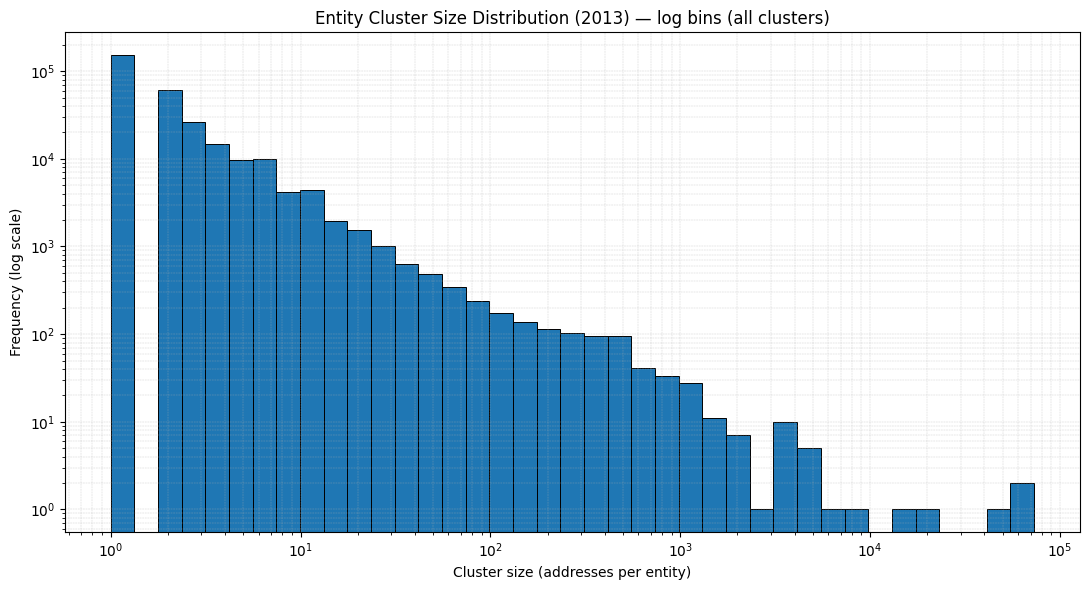

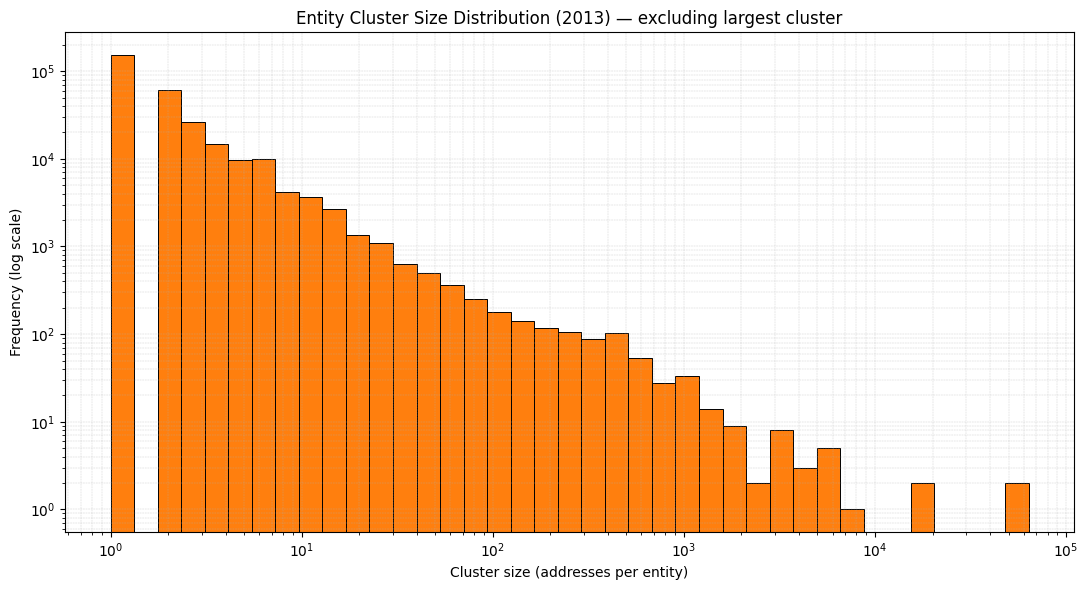

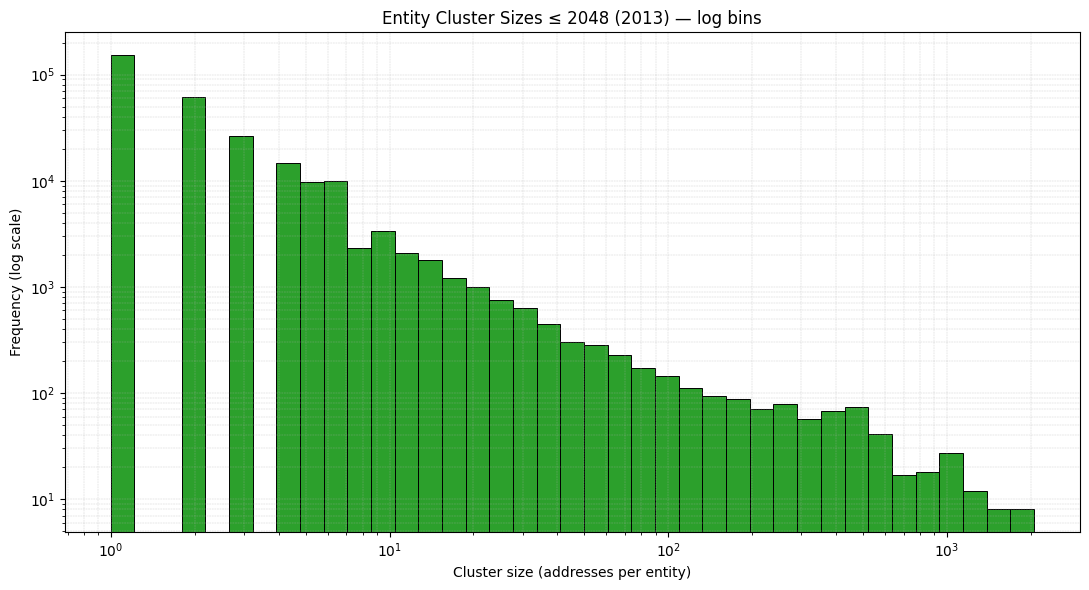

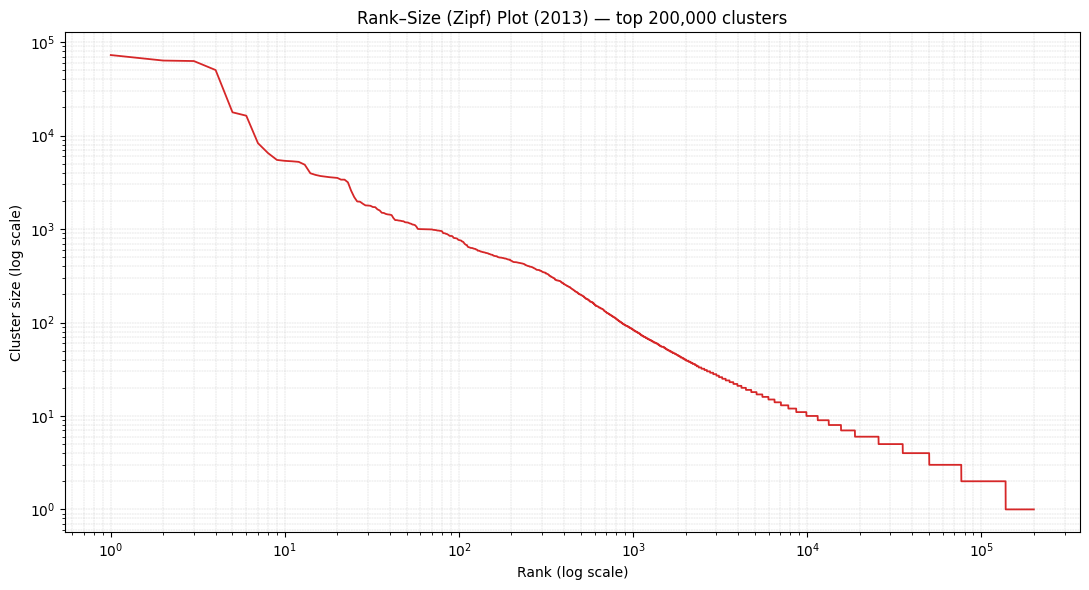

[INFO] Done.


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations

import gc
import glob
import math
import sqlite3
from collections import Counter, defaultdict
from datetime import date, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.auto import tqdm


# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "io": str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

io_paths = sorted(glob.glob(patterns["io"]))
print("Parquet file counts:", {"io": len(io_paths)})

# -----------------------------
# Analysis window: single year
# -----------------------------
ANALYSIS_YEAR = 2013
ANALYSIS_START = date(ANALYSIS_YEAR, 1, 1)
ANALYSIS_END = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive
print(f"[INFO] Analysis window: {ANALYSIS_START} .. {ANALYSIS_END} (exclusive)")

# OPTIONAL: preload outputs before year start so early-year spends resolve.
OUTPOINT_DB_LOOKBACK_DAYS = 365
INDEX_START = ANALYSIS_START - timedelta(days=OUTPOINT_DB_LOOKBACK_DAYS)
print(f"[INFO] Outpoint DB preload start: {INDEX_START} .. {ANALYSIS_END} (exclusive)")

# Whether to create UF nodes for every output address (creates huge singleton universe).
PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS = False

# SQLite outpoint index
OUTPOINT_DB_PATH = OUTPUT_DIR / f"outpoints_{ANALYSIS_YEAR}.sqlite"
RESET_OUTPOINT_DB = True  # set False to reuse DB

# Output mapping file (address -> entity_id)
WRITE_ENTITY_MAPPING = True
ENTITY_MAP_OUT_PATH = OUTPUT_DIR / f"entities_multiinput_change_{ANALYSIS_YEAR}.parquet"
ENTITY_MAP_COMPRESSION = "zstd"
ENTITY_WRITE_BATCH = 1_000_000

# Plot controls
ZIPF_TOP_K = 200_000
FOCUS_MAX_SIZE = 2048
LOG_BINS = 40

# Print controls
TOP_K_CLUSTERS = 20

# -----------------------------
# Heuristic toggles (for A/B tests)
# -----------------------------
# A/B test examples:
#   - multi-input only: ENABLE_MULTI_INPUT=True,  ENABLE_CHANGE=False
#   - change only:      ENABLE_MULTI_INPUT=False, ENABLE_CHANGE=True
#   - both:             True/True
ENABLE_COINJOIN_FILTER = True
ENABLE_MULTI_INPUT = True
ENABLE_CHANGE = False
ENABLE_MERGE_GUARDS = True

# Multi-input policy (improvement #1)
#   "one_output": apply H1 only when spendable outputs == 1
#   "one_or_two_nonmix": allow 2-output txs if NOT mixing-like (still riskier)
MULTI_INPUT_POLICY = "one_output"  # default safest

# Change heuristic: keep strict (improvement #3)
CHANGE_REQUIRE_2_OUTPUTS = True  # keep True for high-precision pass

# -----------------------------
# Conservative transaction / fee controls
# -----------------------------
DUST_SATS = 546

MAX_FEE_ABS_SATS = 50_000_000
MAX_FEE_FRAC = 0.05

MAX_CHANGE_INPUTS_UTXOS = 10
MAX_CHANGE_SPENDABLE_OUTS = 2  # tightened: only 2-output spendable by default (improvement #3)

# "Optimal change" constraint (improvement #3)
# change_val should not exceed (min_input - fee) by much; otherwise the smallest input was unnecessary.
ENABLE_OPTIMAL_CHANGE_CONSTRAINT = True
OPTIMAL_CHANGE_SLACK_SATS = 0  # set >0 if you want to allow small slack (e.g., 1000)

# -----------------------------
# Merge guards (improvement #4)
# -----------------------------
# Absolute cap on merge-resulting component size (prevents mega-collapse)
MAX_MERGED_COMPONENT_SIZE = 1_500_000  # tune; if too small you will under-cluster large services
# Ratio guard: prevent a very large cluster from repeatedly absorbing tiny clusters through noisy edges
MERGE_RATIO_GUARD = True
MERGE_RATIO_MAX = 200  # max(size_big/size_small) allowed for "big merges"
MERGE_RATIO_BIG_CLUSTER_MIN = 50_000  # apply ratio guard only if the bigger cluster is at least this size

# Optional: require repeated evidence for LARGE CHANGE merges (cheap “multi-evidence”)
ENABLE_CHANGE_MERGE_VOTES = True
CHANGE_VOTE_SUM_THRESHOLD = 200_000   # if size(A)+size(B) >= threshold, require votes
CHANGE_VOTES_REQUIRED = 2             # require >=2 independent txs to do that big merge

# -----------------------------
# Performance knobs (patched)
# -----------------------------
OUTPOINT_COMMIT_EVERY_ROWS = 500_000

PREVOUT_HYBRID_THRESHOLD = 5_000
PREVOUT_LOOKUP_CHUNK = 50_000

ITER_BUFFER_IN = 200_000
ITER_BUFFER_OUT = 200_000
ITER_BUFFER_GROUPED = 50_000

GC_EVERY_N_FILES = 100

TQDM_MININTERVAL = 2.0
TQDM_MINITERS = 50
TQDM_POSTFIX_EVERY = 250

# -----------------------------
# Sanity knobs
# -----------------------------
RUN_SANITY_CHECKS = True

RUN_PREVOUT_POLARS_SANITY = False  # quick but only within-file
RUN_PREVOUT_DB_SANITY = True       # meaningful: uses the outpoint DB
PREVOUT_SANITY_SAMPLE_LIMIT = 200_000

PREVOUT_SANITY_PARQUET: str | None = None


# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    """
    Union-Find with:
      - union by rank
      - path compression
      - component sizes (for merge guards)
    """
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []
        self.size: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        self.size.append(1)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def comp_size(self, x: int) -> int:
        return self.size[self.find(x)]

    def union_roots(self, rx: int, ry: int) -> int:
        """Union already-found roots; return new root."""
        if rx == ry:
            return rx
        parent = self.parent
        rank = self.rank
        size = self.size

        if rank[rx] < rank[ry]:
            parent[rx] = ry
            size[ry] += size[rx]
            return ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
            size[rx] += size[ry]
            return rx
        else:
            parent[ry] = rx
            rank[rx] += 1
            size[rx] += size[ry]
            return rx

    def union(self, x: int, y: int) -> int:
        rx = self.find(x)
        ry = self.find(y)
        return self.union_roots(rx, ry)


def addr_type(addr: str) -> str:
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def _count_dupe_values(values: list[int], dust_sats: int) -> tuple[int, int]:
    """
    Returns:
      - max duplicate count among values >= dust
      - number of distinct values >= dust
    """
    if not values:
        return 0, 0
    vals = [v for v in values if v >= dust_sats]
    if not vals:
        return 0, 0
    cnt = Counter(vals)
    return max(cnt.values()), len(cnt)


def detect_mixing_like(
    n_in_utxos: int,
    spendable_outs: list[tuple[str, int]],
    dust_sats: int = DUST_SATS,
) -> bool:
    """
    Cheap but stronger CoinJoin/shared-send detection (improvement #2).
    Designed to reduce false positives in H1 (multi-input) and change.
    """
    n_out = len(spendable_outs)
    if n_in_utxos < 3 or n_out < 3:
        return False

    out_vals = [v for (_a, v) in spendable_outs]
    out_types = [addr_type(a) for (a, _v) in spendable_outs if a is not None]
    unique_vals = len(set(out_vals))
    unique_types = len(set(out_types)) if out_types else 0

    max_dupe, distinct_vals_non_dust = _count_dupe_values(out_vals, dust_sats)

    # Signal A: multiple equal-sized outputs (common in CoinJoin)
    # Your old rule required >=3; relax to >=2 for sensitivity.
    if max_dupe >= 2 and distinct_vals_non_dust >= 2:
        return True

    # Signal B: n_in ≈ n_out (typical CoinJoin shape)
    if abs(n_in_utxos - n_out) <= 1 and min(n_in_utxos, n_out) >= 3:
        return True

    # Signal C: low unique value ratio with enough outputs
    # (many repeated values even if not all identical)
    if n_out >= 4:
        if unique_vals <= (n_out // 2):
            return True

    # Signal D: homogeneous script types + many outputs + repeated values
    if n_out >= 4 and unique_types == 1 and max_dupe >= 2:
        return True

    return False


def multi_input_is_safe(
    n_in_utxos: int,
    spendable_outs: list[tuple[str, int]],
    is_mixing_like: bool,
) -> bool:
    """
    Multi-input policy (improvement #1).
    """
    if n_in_utxos < 2:
        return False
    n_out = len(spendable_outs)

    if MULTI_INPUT_POLICY == "one_output":
        return n_out == 1

    if MULTI_INPUT_POLICY == "one_or_two_nonmix":
        if n_out == 1:
            return True
        if n_out == 2 and not is_mixing_like:
            return True
        return False

    raise ValueError(f"Unknown MULTI_INPUT_POLICY={MULTI_INPUT_POLICY}")


# -----------------------------
# Value normalization: detect BTC vs sats and convert to sats
# -----------------------------
VALUE_UNIT: str | None = None  # "btc" or "sats"


def infer_value_unit_from_sample(sample_vals: list[float]) -> str:
    if not sample_vals:
        return "btc"
    mx = max(sample_vals)
    return "sats" if mx >= 1e6 else "btc"


def value_expr_to_sats() -> pl.Expr:
    if VALUE_UNIT == "sats":
        return pl.col("value").cast(pl.Float64, strict=False).round(0).cast(pl.Int64, strict=False)
    return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)


# -----------------------------
# SQLite outpoint DB (stores address + value_sats)
# -----------------------------
def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")  # ~2GB cache (negative => KB)
    cur.execute("PRAGMA wal_autocheckpoint=5000;")

    conn.isolation_level = None

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            value_sats INTEGER NOT NULL,
            PRIMARY KEY(txid, n)
        ) WITHOUT ROWID;
        """
    )
    return conn


def init_lookup_tables(conn: sqlite3.Connection) -> None:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS keybuf;")
    cur.execute(
        """
        CREATE TEMP TABLE keybuf (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL
        );
        """
    )


def insert_outpoints_no_commit(conn: sqlite3.Connection, rows: list[tuple[str, int, str, int]]) -> None:
    if not rows:
        return
    conn.executemany(
        "INSERT OR IGNORE INTO outpoints(txid, n, address, value_sats) VALUES (?, ?, ?, ?);",
        rows,
    )


def lookup_outpoints_or(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = 500,
) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]
        cur.execute(f"SELECT txid, n, address, value_sats FROM outpoints WHERE {where};", params)
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_join(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = PREVOUT_LOOKUP_CHUNK,
) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))

    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]

        cur.execute("DELETE FROM keybuf;")
        cur.executemany("INSERT INTO keybuf(txid, n) VALUES (?, ?);", chunk)

        cur.execute(
            """
            SELECT k.txid, k.n, o.address, o.value_sats
            FROM keybuf k
            JOIN outpoints o
              ON o.txid = k.txid AND o.n = k.n;
            """
        )
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_hybrid(conn: sqlite3.Connection, keys: list[tuple[str, int]]) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    if len(keys) < PREVOUT_HYBRID_THRESHOLD:
        return lookup_outpoints_or(conn, keys, chunk_size=500)
    return lookup_outpoints_join(conn, keys, chunk_size=PREVOUT_LOOKUP_CHUNK)


# -----------------------------
# Plot helpers
# -----------------------------
def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)


def plot_hist_logbins(
    sizes: np.ndarray,
    title: str,
    color: str,
    bins: int = LOG_BINS,
    max_x: int | None = None,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    if max_x is None:
        max_x = int(sizes.max())

    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(
        sizes,
        bins=b,
        log=True,
        color=color,
        edgecolor="black",
        linewidth=0.7,
    )
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_zipf(
    sizes: np.ndarray,
    title: str,
    color: str,
    top_k: int = ZIPF_TOP_K,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    top_k = min(top_k, sizes.size)
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# -----------------------------
# Sanity checks
# -----------------------------
OUTPUT_DIR_VALUES = {"out", "vout", "output", "o"}
INPUT_DIR_VALUES  = {"in", "vin", "input", "i"}


def run_sanity_checks(
    n_nodes: int,
    node_to_entity: list[int] | np.ndarray | None = None,
    cluster_size_counter: Counter | None = None,
    prevout_lookups: int | None = None,
    prevout_hits: int | None = None,
    top_k: int = 20,
) -> None:
    if cluster_size_counter is None:
        if node_to_entity is None:
            raise ValueError("Provide either node_to_entity or cluster_size_counter.")
        cluster_size_counter = Counter(list(node_to_entity))

    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found (sizes empty).")
        return

    sizes_sorted = sorted(sizes, reverse=True)
    total_nodes_from_sizes = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total_nodes_from_sizes if total_nodes_from_sizes else float("nan")

    print("\n[SANITY] Cluster summary")
    print(f"  UF nodes (n_nodes): {n_nodes:,}")
    print(f"  Total nodes from cluster sizes: {total_nodes_from_sizes:,}")
    if total_nodes_from_sizes != n_nodes:
        print("  [WARN] sum(cluster_sizes) != n_nodes  -> mismatch suggests a bug in mapping logic.")
    print(f"  Entities (clusters): {len(cluster_size_counter):,}")
    print(f"  Largest cluster size: {largest:,}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")

    print(f"\n[SANITY] Top {top_k} cluster sizes:")
    print(" ", sizes_sorted[:top_k])

    def pct(p: float) -> int:
        if not sizes_sorted:
            return 0
        s_asc = sorted(sizes_sorted)
        idx = max(0, min(len(s_asc) - 1, math.ceil(p * len(s_asc)) - 1))
        return int(s_asc[idx])

    med = int(sorted(sizes_sorted)[len(sizes_sorted) // 2])
    print("\n[SANITY] Quick distribution stats")
    print(f"  Median cluster size: {med:,}")
    print(f"  90th percentile cluster size: {pct(0.90):,}")
    print(f"  99th percentile cluster size: {pct(0.99):,}")

    if prevout_lookups is not None and prevout_hits is not None:
        rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
        print("\n[SANITY] Prevout lookup hit-rate (DB)")
        print(f"  Lookups:  {prevout_lookups:,}")
        print(f"  Hits:     {prevout_hits:,}")
        print(f"  Hit-rate: {rate:.2%}")


def prevout_join_sanity_db(conn: sqlite3.Connection, one_io_parquet: str, sample_limit: int = 200_000) -> None:
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","prev_txid","prev_vout"])
    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
          .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
          .head(sample_limit)
    )

    print("\n[PREVOUT-SANITY | DB]")
    print("File:", one_io_parquet)
    print("Vin sample rows:", vin.height)

    if vin.height == 0:
        print("No vin rows in sample.")
        return

    frac_integerlike = (
        vin.with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
           .select(pl.col("is_intlike").mean())
           .item()
    )
    print(f"prev_vout integer-like fraction (sample): {float(frac_integerlike):.6f}")

    vin2 = vin.with_columns(
        pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_vout_i64")
    ).filter(pl.col("prev_vout_i64").is_not_null())

    keys = [
        (prev_txid, int(prev_n))
        for prev_txid, prev_n in vin2.select(["prev_txid", "prev_vout_i64"]).iter_rows(named=False, buffer_size=200_000)
    ]
    if not keys:
        print("No usable keys after casting prev_vout.")
        return

    hits = lookup_outpoints_hybrid(conn, keys)
    resolved = len(hits)
    lookups = len(keys)

    print(f"DB prevout hit-rate (sample): {resolved}/{lookups} = {resolved/lookups:.2%}")

    unresolved = []
    for k in keys[:5000]:
        if k not in hits:
            unresolved.append(k)
            if len(unresolved) >= 10:
                break
    if unresolved:
        print("Sample unresolved (prev_txid, prev_n):")
        for k in unresolved:
            print(" ", k)
    else:
        print("No unresolved keys in first 5000 keys (good sign).")


def pick_default_sanity_parquet(eligible: list[tuple[str, date]]) -> str | None:
    for p, d in eligible:
        if ANALYSIS_START <= d < ANALYSIS_END:
            return p
    return eligible[0][0] if eligible else None


# -----------------------------
# Init structures
# -----------------------------
print(f"Found {len(io_paths)} io parquet files (all years).")

conn = open_outpoint_db(OUTPOINT_DB_PATH, RESET_OUTPOINT_DB)
init_lookup_tables(conn)
print(f"[INFO] Outpoint DB: {OUTPOINT_DB_PATH} (reset={RESET_OUTPOINT_DB})")

conn.execute("BEGIN;")
pending_outpoint_rows = 0

uf = UnionFind()
addr_to_id: dict[str, int] = {}

seen_output_flags = bytearray()
multi_change_flags = bytearray()

seen_output_addrs: set[str] | None = None
if not PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
    seen_output_addrs = set()

n_files_indexed = 0
n_files_analyzed = 0

n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

n_prevout_lookups = 0
n_prevout_hits = 0

# Merge diagnostics
n_union_attempts = 0
n_unions_applied = 0
n_unions_skipped_guards = 0
n_unions_applied_h1 = 0
n_unions_applied_change = 0

# Optional “votes” for large change merges (root-pair -> count)
change_merge_votes: dict[tuple[int, int], int] = {}

DIR_NEEDS_NORMALIZATION: bool | None = None


def ensure_flag_capacity(idx: int) -> None:
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


def union_guarded(a: int, b: int, reason: str) -> bool:
    """
    Apply union with merge guards (improvement #4).
    Returns True if union applied, else False.
    """
    global n_union_attempts, n_unions_applied, n_unions_skipped_guards, n_unions_applied_h1, n_unions_applied_change

    n_union_attempts += 1
    ra = uf.find(a)
    rb = uf.find(b)
    if ra == rb:
        return False

    if not ENABLE_MERGE_GUARDS:
        uf.union_roots(ra, rb)
        n_unions_applied += 1
        if reason == "H1":
            n_unions_applied_h1 += 1
        elif reason == "CHANGE":
            n_unions_applied_change += 1
        return True

    sa = uf.size[ra]
    sb = uf.size[rb]
    s_big = sa if sa >= sb else sb
    s_small = sb if sa >= sb else sa
    merged = sa + sb

    # Absolute cap
    if merged > MAX_MERGED_COMPONENT_SIZE:
        n_unions_skipped_guards += 1
        return False

    # Ratio guard (mostly relevant for noisy CHANGE edges)
    if MERGE_RATIO_GUARD and s_small > 0 and s_big >= MERGE_RATIO_BIG_CLUSTER_MIN:
        if (s_big / s_small) > MERGE_RATIO_MAX:
            n_unions_skipped_guards += 1
            return False

    # Optional “votes required” for large CHANGE merges
    if ENABLE_CHANGE_MERGE_VOTES and reason == "CHANGE" and merged >= CHANGE_VOTE_SUM_THRESHOLD:
        r0, r1 = (ra, rb) if ra < rb else (rb, ra)
        k = (r0, r1)
        change_merge_votes[k] = change_merge_votes.get(k, 0) + 1
        if change_merge_votes[k] < CHANGE_VOTES_REQUIRED:
            n_unions_skipped_guards += 1
            return False

    uf.union_roots(ra, rb)
    n_unions_applied += 1
    if reason == "H1":
        n_unions_applied_h1 += 1
    elif reason == "CHANGE":
        n_unions_applied_change += 1
    return True


# -----------------------------
# Pre-filter eligible files (accurate tqdm total)
# -----------------------------
eligible: list[tuple[str, date]] = []
for path in io_paths:
    d = extract_day_from_path(path)
    if d is None:
        continue
    if INDEX_START <= d < ANALYSIS_END:
        eligible.append((path, d))

n_preload_total = sum(1 for _p, d in eligible if d < ANALYSIS_START)
n_analysis_total = len(eligible) - n_preload_total
print(f"[INFO] Eligible files in window: {len(eligible)}  (preload={n_preload_total}, analysis={n_analysis_total})")

sanity_parquet = PREVOUT_SANITY_PARQUET or pick_default_sanity_parquet(eligible)
if RUN_SANITY_CHECKS and sanity_parquet:
    print(f"[INFO] Sanity parquet selected: {sanity_parquet}")

# -----------------------------
# Main loop
# -----------------------------
pbar = tqdm(
    eligible,
    total=len(eligible),
    unit="file",
    dynamic_ncols=True,
    mininterval=TQDM_MININTERVAL,
    miniters=TQDM_MINITERS,
    smoothing=0,
    desc="Processing parquet",
)

for i, (path, file_day) in enumerate(pbar, start=1):
    in_analysis = (ANALYSIS_START <= file_day < ANALYSIS_END)

    if (i % TQDM_POSTFIX_EVERY) == 0:
        pbar.set_postfix_str(f"{'analysis' if in_analysis else 'preload'} day={file_day}")

    if in_analysis:
        n_files_analyzed += 1
        if n_files_analyzed <= 5:
            tqdm.write(f"[{n_files_analyzed}] Processing {path} (day={file_day}) ...")
        elif (n_files_analyzed % 250) == 0:
            tqdm.write(f"[{n_files_analyzed}] Processing ... (day={file_day})")
    else:
        n_files_indexed += 1
        if n_files_indexed <= 3:
            tqdm.write(f"[preload {n_files_indexed}] Indexing outputs only: {path} (day={file_day}) ...")

    df = pl.read_parquet(
        path,
        columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"],
    )

    if DIR_NEEDS_NORMALIZATION is None:
        dir_uniques = (
            df.select(pl.col("dir").cast(pl.Utf8, strict=False).unique())
            .to_series()
            .to_list()
        )
        needs = False
        for d in dir_uniques:
            if d is None:
                continue
            s = str(d)
            if s not in ("in", "out") and s.lower() in ("in", "out"):
                needs = True
                break
        DIR_NEEDS_NORMALIZATION = needs

        if in_analysis and n_files_analyzed == 1:
            tqdm.write(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    if DIR_NEEDS_NORMALIZATION:
        df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

    if VALUE_UNIT is None:
        sample = (
            df.filter(pl.col("dir") == "out")
            .select(pl.col("value").cast(pl.Float64, strict=False))
            .drop_nulls()
            .head(5000)
            .to_series()
            .to_list()
        )
        VALUE_UNIT = infer_value_unit_from_sample(sample)
        tqdm.write(f"[INFO] Detected value unit: {VALUE_UNIT}  (all internal amount logic uses satoshis)")

    # -------------------------
    # 1) Index OUTPUTS into outpoint DB
    # -------------------------
    out_all = (
        df.filter(pl.col("dir") == "out")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("n").is_not_null())
        .select(
            pl.col("txid"),
            pl.col("n").cast(pl.Int64, strict=False).alias("n"),
            pl.col("address"),
            value_expr_to_sats().alias("value_sats"),
        )
    )

    out_for_db = out_all.filter(pl.col("address").is_not_null()).filter(pl.col("value_sats").is_not_null())
    if out_for_db.height > 0:
        rows = [
            (txid, int(n), addr, int(vs))
            for txid, n, addr, vs in out_for_db.select(["txid", "n", "address", "value_sats"]).iter_rows(
                named=False, buffer_size=ITER_BUFFER_OUT
            )
        ]
        insert_outpoints_no_commit(conn, rows)
        pending_outpoint_rows += len(rows)

        if pending_outpoint_rows >= OUTPOINT_COMMIT_EVERY_ROWS:
            conn.execute("COMMIT;")
            conn.execute("BEGIN;")
            pending_outpoint_rows = 0

        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for addr in out_for_db.select(pl.col("address").unique()).to_series().to_list():
                _ = get_addr_id(addr)

    if not in_analysis:
        del df, out_all, out_for_db
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    # -------------------------
    # 2) Resolve INPUT addresses via prev outpoints
    # -------------------------
    in_df = (
        df.filter(pl.col("dir") == "in")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("prev_txid").is_not_null())
        .filter(pl.col("prev_vout").is_not_null())
        .select(
            pl.col("txid").alias("spend_txid"),
            pl.col("prev_txid"),
            pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
        )
        .filter(pl.col("prev_n").is_not_null())
    )

    del df
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

    input_utxo_count: dict[str, int] = defaultdict(int)
    resolved_utxo_count: dict[str, int] = defaultdict(int)
    sum_inputs_sats: dict[str, int] = defaultdict(int)
    min_input_sats: dict[str, int] = {}
    needed_keys: list[tuple[str, int]] = []
    spend_rows: list[tuple[str, str, int]] = []

    if in_df.height > 0:
        for spend_txid, prev_txid, prev_n in in_df.iter_rows(named=False, buffer_size=ITER_BUFFER_IN):
            prev_n_int = int(prev_n)
            input_utxo_count[spend_txid] += 1
            needed_keys.append((prev_txid, prev_n_int))
            spend_rows.append((spend_txid, prev_txid, prev_n_int))

    del in_df

    n_prevout_lookups += len(needed_keys)
    prevout_map = lookup_outpoints_hybrid(conn, needed_keys)
    n_prevout_hits += len(prevout_map)

    inputs_by_txid: dict[str, set[str]] = defaultdict(set)
    for spend_txid, prev_txid, prev_n_int in spend_rows:
        hit = prevout_map.get((prev_txid, prev_n_int))
        if hit:
            addr, val_sats = hit
            v = int(val_sats)
            inputs_by_txid[spend_txid].add(addr)
            resolved_utxo_count[spend_txid] += 1
            sum_inputs_sats[spend_txid] += v
            cur_min = min_input_sats.get(spend_txid)
            if cur_min is None or v < cur_min:
                min_input_sats[spend_txid] = v

    # -------------------------
    # 3) Group outputs per tx and run heuristics
    # -------------------------
    if out_all.height == 0:
        del out_all, out_for_db, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    vout_grouped = (
        out_all.group_by("txid")
        .agg(
            pl.col("address").alias("out_addrs_all"),
            pl.col("value_sats").alias("out_values_sats_all"),
        )
    )

    del out_all, out_for_db

    if vout_grouped.height == 0:
        del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    for txid, out_addrs_all, out_values_all in vout_grouped.select(
        ["txid", "out_addrs_all", "out_values_sats_all"]
    ).iter_rows(named=False, buffer_size=ITER_BUFFER_GROUPED):

        if not out_addrs_all or not out_values_all:
            continue

        n_in_utxos = input_utxo_count.get(txid, 0)
        if n_in_utxos == 0:
            continue

        n_txs_total += 1

        outputs: list[tuple[str | None, int]] = []
        sum_outputs_sats = 0
        for a, v in zip(out_addrs_all, out_values_all):
            if v is None:
                continue
            vi = int(v)
            outputs.append((a, vi))
            sum_outputs_sats += vi

        spendable = [(a, v) for (a, v) in outputs if a is not None and v >= DUST_SATS]

        # Always mark outputs as seen, even if we skip tx
        def mark_outputs_seen() -> None:
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a, _v in outputs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a, _v in outputs:
                    if a is not None:
                        seen_output_addrs.add(a)

        # If no spendable outputs, nothing to do
        if not spendable:
            mark_outputs_seen()
            continue

        # Determine mixing-like (improvement #2)
        is_mixing_like = False
        if ENABLE_COINJOIN_FILTER:
            is_mixing_like = detect_mixing_like(n_in_utxos, spendable, dust_sats=DUST_SATS)
            if is_mixing_like:
                n_txs_coinjoin_flagged += 1
                mark_outputs_seen()
                continue

        in_addrs_set = inputs_by_txid.get(txid)
        if not in_addrs_set:
            mark_outputs_seen()
            continue

        in_addrs = list(in_addrs_set)

        # --- Multi-input heuristic (improvement #1): apply only if SAFE under policy ---
        if ENABLE_MULTI_INPUT and multi_input_is_safe(n_in_utxos, spendable, is_mixing_like):
            n_txs_with_multiinput += 1
            if len(in_addrs) >= 2:
                in_ids = [get_addr_id(a) for a in in_addrs]
                for idx in in_ids:
                    multi_change_flags[idx] |= 1
                first_id = in_ids[0]
                for idx in in_ids[1:]:
                    union_guarded(first_id, idx, reason="H1")
            else:
                idx = get_addr_id(in_addrs[0])
                multi_change_flags[idx] |= 1

        # --- Change heuristic (improvement #3): tightened to 2-output spendable regime ---
        if ENABLE_CHANGE:
            n_spendable_out = len(spendable)

            if CHANGE_REQUIRE_2_OUTPUTS and n_spendable_out != 2:
                mark_outputs_seen()
                continue

            # Keep your input count bound (still useful)
            if n_in_utxos > MAX_CHANGE_INPUTS_UTXOS:
                mark_outputs_seen()
                continue

            if n_spendable_out > MAX_CHANGE_SPENDABLE_OUTS:
                mark_outputs_seen()
                continue

            # Require fully resolved inputs (keeps fee/min-input constraints meaningful)
            resolved_cnt = resolved_utxo_count.get(txid, 0)
            if resolved_cnt != n_in_utxos:
                mark_outputs_seen()
                continue

            # Require input address types uniform (your prior constraint)
            in_types = [addr_type(a) for a in in_addrs]
            if len(set(in_types)) != 1:
                mark_outputs_seen()
                continue
            majority_type = in_types[0]

            # Ensure outputs are distinct addresses
            spendable_addrs = [a for (a, _v) in spendable]
            if len(spendable_addrs) != len(set(spendable_addrs)):
                mark_outputs_seen()
                continue

            in_addr_set_fast = set(in_addrs)
            candidates: list[tuple[str, int]] = []
            for a, v in spendable:
                # candidate must be:
                #  - not one of the inputs
                #  - same address type as inputs
                #  - fresh output address (not previously seen as output)
                if a in in_addr_set_fast:
                    continue
                if addr_type(a) != majority_type:
                    continue

                if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                    a_id = get_addr_id(a)
                    if seen_output_flags[a_id]:
                        continue
                else:
                    if a in seen_output_addrs:
                        continue

                candidates.append((a, v))

            if len(candidates) != 1:
                mark_outputs_seen()
                continue

            change_addr, change_val = candidates[0]
            sum_in = sum_inputs_sats.get(txid, 0)
            fee = sum_in - sum_outputs_sats

            if sum_in <= 0 or fee < 0:
                mark_outputs_seen()
                continue
            if fee > MAX_FEE_ABS_SATS or fee > int(MAX_FEE_FRAC * sum_in):
                mark_outputs_seen()
                continue

            # 2-output: enforce "change is the smaller output" (your prior conservative rule)
            other_addr, other_val = (spendable[0] if spendable[1][0] == change_addr else spendable[1])
            if not (change_val < other_val):
                mark_outputs_seen()
                continue

            # Optimal-change constraint (improvement #3)
            if ENABLE_OPTIMAL_CHANGE_CONSTRAINT:
                mn = min_input_sats.get(txid)
                if mn is None:
                    mark_outputs_seen()
                    continue
                # If change is bigger than (min_input - fee), the smallest input was likely unnecessary.
                # Allow slack if needed.
                if change_val > (mn - fee + OPTIMAL_CHANGE_SLACK_SATS):
                    mark_outputs_seen()
                    continue

            # Apply union: connect change to (some) input address
            change_id = get_addr_id(change_addr)
            multi_change_flags[change_id] |= 2
            n_txs_with_change_detected += 1
            union_guarded(get_addr_id(in_addrs[0]), change_id, reason="CHANGE")

        mark_outputs_seen()

    del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

pbar.close()
conn.execute("COMMIT;")


# -----------------------------
# Finalize entity mapping + stats
# -----------------------------
print("\nFinalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with UF nodes: {n_nodes:,}")
hit_rate = (n_prevout_hits / max(1, n_prevout_lookups))
print(f"[INFO] prevout lookups: {n_prevout_lookups:,}  hits: {n_prevout_hits:,}  hit-rate: {hit_rate:.3%}")

if n_nodes == 0:
    print("No union-find nodes created. This means no input addresses were resolved (or heuristics never triggered).")
    conn.close()
    raise SystemExit(0)

node_to_entity = np.empty(n_nodes, dtype=np.int32)
root_to_entity: dict[int, int] = {}
next_entity_id = 0

for node in range(n_nodes):
    root = uf.find(node)
    ent = root_to_entity.get(root)
    if ent is None:
        ent = next_entity_id
        root_to_entity[root] = ent
        next_entity_id += 1
    node_to_entity[node] = ent

n_entities = next_entity_id
print(f"Number of entities (clusters): {n_entities:,}")

counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
cluster_sizes = counts[counts > 0]

largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
largest_frac = (largest / n_nodes) if n_nodes else float("nan")

top_k = min(TOP_K_CLUSTERS, n_entities)
top_ids = np.argpartition(counts, -top_k)[-top_k:]
top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

print("\n[TOP CLUSTERS]")
for rank, eid in enumerate(top_ids_sorted, start=1):
    sz = int(counts[eid])
    frac = (sz / n_nodes) if n_nodes else float("nan")
    print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>10,d}  frac={frac:>7.2%}")

q50, q90, q99 = np.quantile(cluster_sizes, [0.5, 0.9, 0.99])
print("\n[CLUSTER STATS]")
print(f"  Entities: {n_entities:,}")
print(f"  Largest cluster size: {largest:,}")
print(f"  Largest cluster fraction of nodes: {largest_frac:.2%}")
print(f"  Median cluster size: {int(q50)}")
print(f"  90th percentile: {int(q90)}")
print(f"  99th percentile: {int(q99)}")

flags_view = multi_change_flags[:n_nodes]
n_addrs_multi = sum(1 for v in flags_view if (v & 1))
n_addrs_change = sum(1 for v in flags_view if (v & 2))
n_addrs_touched = sum(1 for v in flags_view if (v & 3))

print("\n[HEURISTIC COVERAGE (node-level)]")
print(f"  Total txs processed (>=1 input UTXO): {n_txs_total:,}")
print(f"  Mixing-like skipped: {n_txs_coinjoin_flagged:,}")
print(f"  Multi-input txs (SAFE policy applied): {n_txs_with_multiinput:,}")
print(f"  Change detected + unioned (tight): {n_txs_with_change_detected:,}")
print(f"  Nodes marked multi-input: {n_addrs_multi:,}")
print(f"  Nodes marked change: {n_addrs_change:,}")
print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}")

print("\n[UNION DIAGNOSTICS]")
print(f"  Union attempts: {n_union_attempts:,}")
print(f"  Unions applied: {n_unions_applied:,}")
print(f"    - applied via H1:     {n_unions_applied_h1:,}")
print(f"    - applied via CHANGE: {n_unions_applied_change:,}")
print(f"  Unions skipped by guards/votes: {n_unions_skipped_guards:,}")
if ENABLE_CHANGE_MERGE_VOTES:
    print(f"  Change merge vote pairs tracked: {len(change_merge_votes):,}")

# -----------------------------
# Sanity checks
# -----------------------------
if RUN_SANITY_CHECKS:
    run_sanity_checks(
        n_nodes=n_nodes,
        node_to_entity=node_to_entity,
        prevout_lookups=n_prevout_lookups,
        prevout_hits=n_prevout_hits,
        top_k=20,
    )

    if sanity_parquet and RUN_PREVOUT_DB_SANITY:
        prevout_join_sanity_db(conn, sanity_parquet, sample_limit=PREVOUT_SANITY_SAMPLE_LIMIT)

# -----------------------------
# Write address -> entity_id mapping (chunked parquet)
# -----------------------------
if WRITE_ENTITY_MAPPING:
    print(f"\n[WRITE] Writing entity mapping to: {ENTITY_MAP_OUT_PATH}")
    if ENTITY_MAP_OUT_PATH.exists():
        ENTITY_MAP_OUT_PATH.unlink()

    writer: pq.ParquetWriter | None = None
    batch_addrs: list[str] = []
    batch_eids: list[int] = []
    written = 0

    for addr, node_id in addr_to_id.items():
        batch_addrs.append(addr)
        batch_eids.append(int(node_to_entity[node_id]))

        if len(batch_addrs) >= ENTITY_WRITE_BATCH:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(ENTITY_MAP_OUT_PATH),
                    table.schema,
                    compression=ENTITY_MAP_COMPRESSION,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            batch_addrs.clear()
            batch_eids.clear()
            print(f"  [WRITE] rows written: {written:,}")

    if batch_addrs:
        table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
        if writer is None:
            writer = pq.ParquetWriter(
                str(ENTITY_MAP_OUT_PATH),
                table.schema,
                compression=ENTITY_MAP_COMPRESSION,
                use_dictionary=True,
            )
        writer.write_table(table)
        written += len(batch_addrs)
        print(f"  [WRITE] rows written: {written:,}")

    if writer is not None:
        writer.close()

    print("[WRITE] Done.")

# -----------------------------
# Plotting
# -----------------------------
print("\n[PLOT] Generating plots...")

plot_hist_logbins(
    sizes=cluster_sizes,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — log bins (all clusters)",
    color="tab:blue",
    bins=LOG_BINS,
)

if largest > 0:
    sizes_excl = cluster_sizes[cluster_sizes != largest]
else:
    sizes_excl = cluster_sizes

plot_hist_logbins(
    sizes=sizes_excl,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — excluding largest cluster",
    color="tab:orange",
    bins=LOG_BINS,
)

sizes_focus = cluster_sizes[cluster_sizes <= FOCUS_MAX_SIZE]
plot_hist_logbins(
    sizes=sizes_focus,
    title=f"Entity Cluster Sizes ≤ {FOCUS_MAX_SIZE} ({ANALYSIS_YEAR}) — log bins",
    color="tab:green",
    bins=LOG_BINS,
    max_x=FOCUS_MAX_SIZE,
)

plot_zipf(
    sizes=cluster_sizes,
    title=f"Rank–Size (Zipf) Plot ({ANALYSIS_YEAR}) — top {min(ZIPF_TOP_K, cluster_sizes.size):,} clusters",
    color="tab:red",
    top_k=ZIPF_TOP_K,
)

conn.close()
print("[INFO] Done.")


Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2012-01-02 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[INFO] Outpoint DB: /media/vatereal/Main/outputs/outpoints_2013.sqlite (reset=True)
[INFO] Eligible files in window: 753  (preload=375, analysis=378)
[INFO] Sanity parquet selected: /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet


Processing parquet:   0%|          | 0/753 [00:00<?, ?file/s]

[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-02/io-000160190-000160340.parquet (day=2012-01-02) ...
[INFO] Detected value unit: btc  (all internal amount logic uses satoshis)
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-03/io-000160341-000160499.parquet (day=2012-01-03) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-04/io-000160500-000160648.parquet (day=2012-01-04) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[2] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[3] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[4] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000215033-000215039.parquet (day=2013-01-03) ...
[5] Processing /media/vatereal/Main/parquet/io/day=2013-01-04/io-00

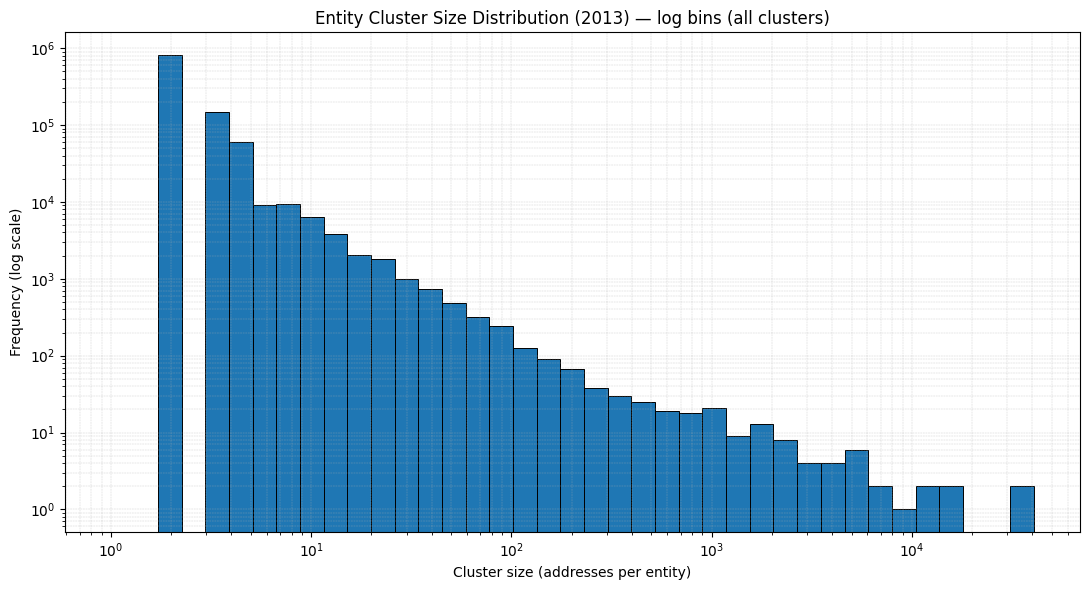

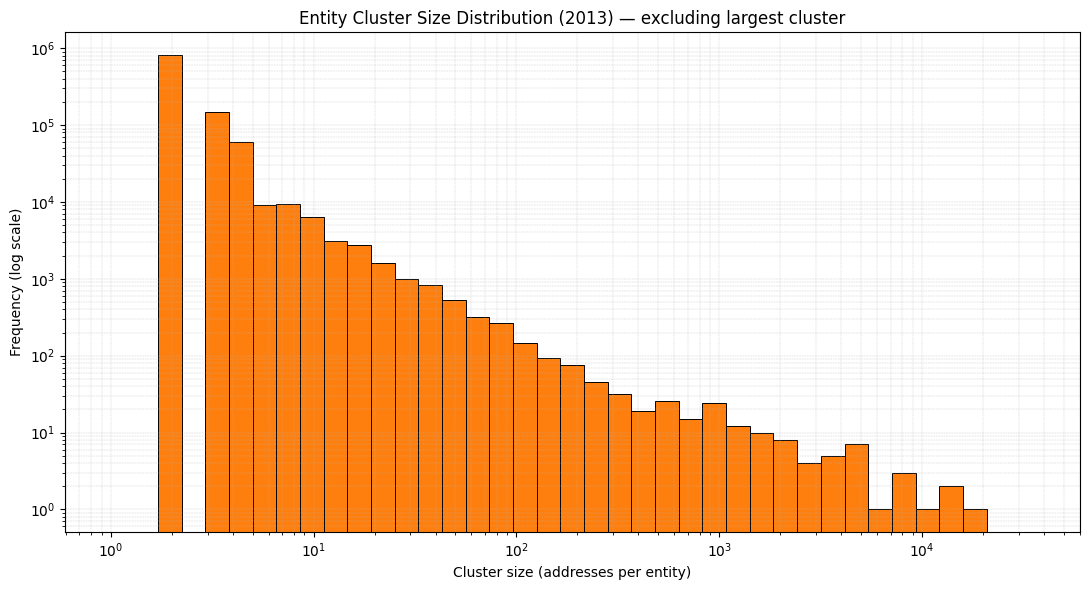

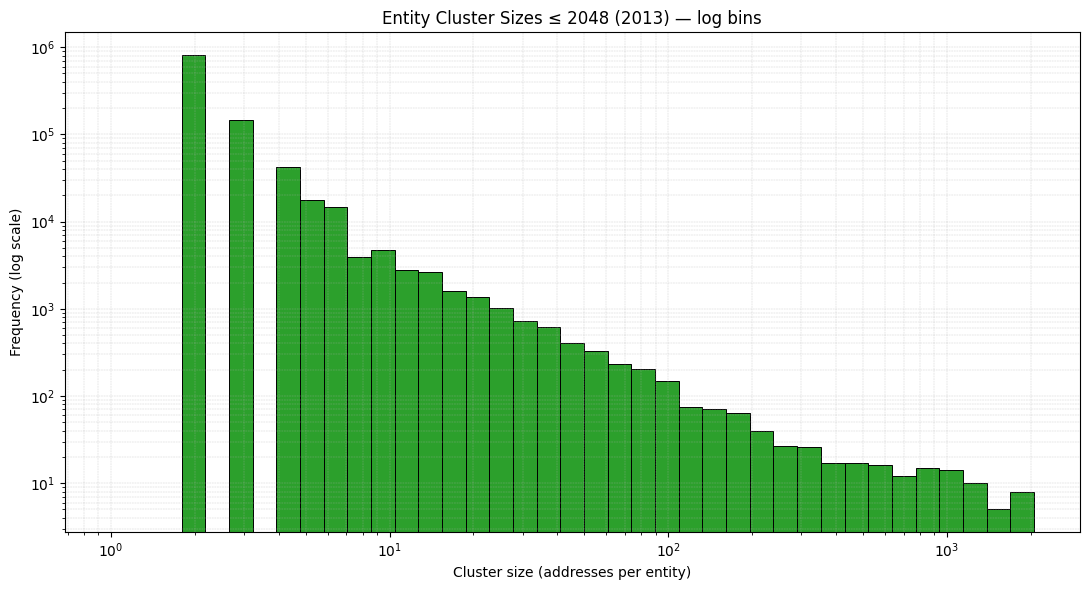

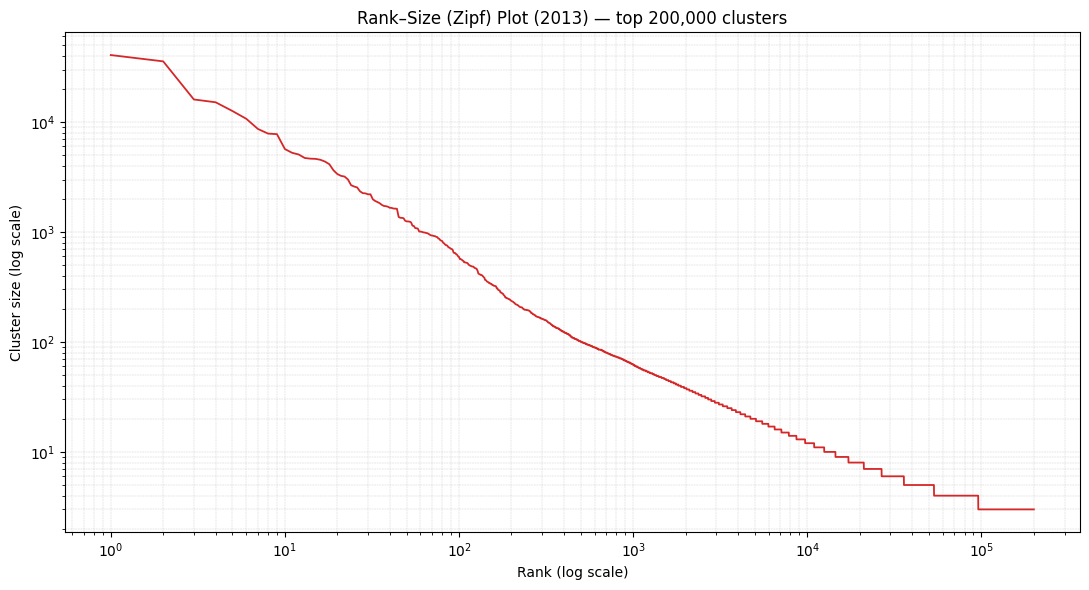

[INFO] Done.


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations

import gc
import glob
import math
import sqlite3
from collections import Counter, defaultdict
from datetime import date, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.auto import tqdm


# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "io": str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

io_paths = sorted(glob.glob(patterns["io"]))
print("Parquet file counts:", {"io": len(io_paths)})

# -----------------------------
# Analysis window: single year
# -----------------------------
ANALYSIS_YEAR = 2013
ANALYSIS_START = date(ANALYSIS_YEAR, 1, 1)
ANALYSIS_END = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive
print(f"[INFO] Analysis window: {ANALYSIS_START} .. {ANALYSIS_END} (exclusive)")

# OPTIONAL: preload outputs before year start so early-year spends resolve.
OUTPOINT_DB_LOOKBACK_DAYS = 365
INDEX_START = ANALYSIS_START - timedelta(days=OUTPOINT_DB_LOOKBACK_DAYS)
print(f"[INFO] Outpoint DB preload start: {INDEX_START} .. {ANALYSIS_END} (exclusive)")

# Whether to create UF nodes for every output address (creates huge singleton universe).
PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS = False

# SQLite outpoint index
OUTPOINT_DB_PATH = OUTPUT_DIR / f"outpoints_{ANALYSIS_YEAR}.sqlite"
RESET_OUTPOINT_DB = True  # set False to reuse DB

# Output mapping file (address -> entity_id)
WRITE_ENTITY_MAPPING = True
ENTITY_MAP_OUT_PATH = OUTPUT_DIR / f"entities_multiinput_change_{ANALYSIS_YEAR}.parquet"
ENTITY_MAP_COMPRESSION = "zstd"
ENTITY_WRITE_BATCH = 1_000_000

# Plot controls
ZIPF_TOP_K = 200_000
FOCUS_MAX_SIZE = 2048
LOG_BINS = 40

# Print controls
TOP_K_CLUSTERS = 20

# -----------------------------
# Heuristic toggles (for A/B tests)
# -----------------------------
# A/B test examples:
#   - multi-input only: ENABLE_MULTI_INPUT=True,  ENABLE_CHANGE=False
#   - change only:      ENABLE_MULTI_INPUT=False, ENABLE_CHANGE=True
#   - both:             True/True
ENABLE_COINJOIN_FILTER = True
ENABLE_MULTI_INPUT = False
ENABLE_CHANGE = True
ENABLE_MERGE_GUARDS = True

# Multi-input policy (improvement #1)
#   "one_output": apply H1 only when spendable outputs == 1
#   "one_or_two_nonmix": allow 2-output txs if NOT mixing-like (still riskier)
MULTI_INPUT_POLICY = "one_output"  # default safest

# Change heuristic: keep strict (improvement #3)
CHANGE_REQUIRE_2_OUTPUTS = True  # keep True for high-precision pass

# -----------------------------
# Conservative transaction / fee controls
# -----------------------------
DUST_SATS = 546

MAX_FEE_ABS_SATS = 50_000_000
MAX_FEE_FRAC = 0.05

MAX_CHANGE_INPUTS_UTXOS = 10
MAX_CHANGE_SPENDABLE_OUTS = 2  # tightened: only 2-output spendable by default (improvement #3)

# "Optimal change" constraint (improvement #3)
# change_val should not exceed (min_input - fee) by much; otherwise the smallest input was unnecessary.
ENABLE_OPTIMAL_CHANGE_CONSTRAINT = True
OPTIMAL_CHANGE_SLACK_SATS = 0  # set >0 if you want to allow small slack (e.g., 1000)

# -----------------------------
# Merge guards (improvement #4)
# -----------------------------
# Absolute cap on merge-resulting component size (prevents mega-collapse)
MAX_MERGED_COMPONENT_SIZE = 1_500_000  # tune; if too small you will under-cluster large services
# Ratio guard: prevent a very large cluster from repeatedly absorbing tiny clusters through noisy edges
MERGE_RATIO_GUARD = True
MERGE_RATIO_MAX = 200  # max(size_big/size_small) allowed for "big merges"
MERGE_RATIO_BIG_CLUSTER_MIN = 50_000  # apply ratio guard only if the bigger cluster is at least this size

# Optional: require repeated evidence for LARGE CHANGE merges (cheap “multi-evidence”)
ENABLE_CHANGE_MERGE_VOTES = True
CHANGE_VOTE_SUM_THRESHOLD = 200_000   # if size(A)+size(B) >= threshold, require votes
CHANGE_VOTES_REQUIRED = 2             # require >=2 independent txs to do that big merge

# -----------------------------
# Performance knobs (patched)
# -----------------------------
OUTPOINT_COMMIT_EVERY_ROWS = 500_000

PREVOUT_HYBRID_THRESHOLD = 5_000
PREVOUT_LOOKUP_CHUNK = 50_000

ITER_BUFFER_IN = 200_000
ITER_BUFFER_OUT = 200_000
ITER_BUFFER_GROUPED = 50_000

GC_EVERY_N_FILES = 100

TQDM_MININTERVAL = 2.0
TQDM_MINITERS = 50
TQDM_POSTFIX_EVERY = 250

# -----------------------------
# Sanity knobs
# -----------------------------
RUN_SANITY_CHECKS = True

RUN_PREVOUT_POLARS_SANITY = False  # quick but only within-file
RUN_PREVOUT_DB_SANITY = True       # meaningful: uses the outpoint DB
PREVOUT_SANITY_SAMPLE_LIMIT = 200_000

PREVOUT_SANITY_PARQUET: str | None = None


# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    """
    Union-Find with:
      - union by rank
      - path compression
      - component sizes (for merge guards)
    """
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []
        self.size: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        self.size.append(1)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def comp_size(self, x: int) -> int:
        return self.size[self.find(x)]

    def union_roots(self, rx: int, ry: int) -> int:
        """Union already-found roots; return new root."""
        if rx == ry:
            return rx
        parent = self.parent
        rank = self.rank
        size = self.size

        if rank[rx] < rank[ry]:
            parent[rx] = ry
            size[ry] += size[rx]
            return ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
            size[rx] += size[ry]
            return rx
        else:
            parent[ry] = rx
            rank[rx] += 1
            size[rx] += size[ry]
            return rx

    def union(self, x: int, y: int) -> int:
        rx = self.find(x)
        ry = self.find(y)
        return self.union_roots(rx, ry)


def addr_type(addr: str) -> str:
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def _count_dupe_values(values: list[int], dust_sats: int) -> tuple[int, int]:
    """
    Returns:
      - max duplicate count among values >= dust
      - number of distinct values >= dust
    """
    if not values:
        return 0, 0
    vals = [v for v in values if v >= dust_sats]
    if not vals:
        return 0, 0
    cnt = Counter(vals)
    return max(cnt.values()), len(cnt)


def detect_mixing_like(
    n_in_utxos: int,
    spendable_outs: list[tuple[str, int]],
    dust_sats: int = DUST_SATS,
) -> bool:
    """
    Cheap but stronger CoinJoin/shared-send detection (improvement #2).
    Designed to reduce false positives in H1 (multi-input) and change.
    """
    n_out = len(spendable_outs)
    if n_in_utxos < 3 or n_out < 3:
        return False

    out_vals = [v for (_a, v) in spendable_outs]
    out_types = [addr_type(a) for (a, _v) in spendable_outs if a is not None]
    unique_vals = len(set(out_vals))
    unique_types = len(set(out_types)) if out_types else 0

    max_dupe, distinct_vals_non_dust = _count_dupe_values(out_vals, dust_sats)

    # Signal A: multiple equal-sized outputs (common in CoinJoin)
    # Your old rule required >=3; relax to >=2 for sensitivity.
    if max_dupe >= 2 and distinct_vals_non_dust >= 2:
        return True

    # Signal B: n_in ≈ n_out (typical CoinJoin shape)
    if abs(n_in_utxos - n_out) <= 1 and min(n_in_utxos, n_out) >= 3:
        return True

    # Signal C: low unique value ratio with enough outputs
    # (many repeated values even if not all identical)
    if n_out >= 4:
        if unique_vals <= (n_out // 2):
            return True

    # Signal D: homogeneous script types + many outputs + repeated values
    if n_out >= 4 and unique_types == 1 and max_dupe >= 2:
        return True

    return False


def multi_input_is_safe(
    n_in_utxos: int,
    spendable_outs: list[tuple[str, int]],
    is_mixing_like: bool,
) -> bool:
    """
    Multi-input policy (improvement #1).
    """
    if n_in_utxos < 2:
        return False
    n_out = len(spendable_outs)

    if MULTI_INPUT_POLICY == "one_output":
        return n_out == 1

    if MULTI_INPUT_POLICY == "one_or_two_nonmix":
        if n_out == 1:
            return True
        if n_out == 2 and not is_mixing_like:
            return True
        return False

    raise ValueError(f"Unknown MULTI_INPUT_POLICY={MULTI_INPUT_POLICY}")


# -----------------------------
# Value normalization: detect BTC vs sats and convert to sats
# -----------------------------
VALUE_UNIT: str | None = None  # "btc" or "sats"


def infer_value_unit_from_sample(sample_vals: list[float]) -> str:
    if not sample_vals:
        return "btc"
    mx = max(sample_vals)
    return "sats" if mx >= 1e6 else "btc"


def value_expr_to_sats() -> pl.Expr:
    if VALUE_UNIT == "sats":
        return pl.col("value").cast(pl.Float64, strict=False).round(0).cast(pl.Int64, strict=False)
    return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)


# -----------------------------
# SQLite outpoint DB (stores address + value_sats)
# -----------------------------
def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")  # ~2GB cache (negative => KB)
    cur.execute("PRAGMA wal_autocheckpoint=5000;")

    conn.isolation_level = None

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            value_sats INTEGER NOT NULL,
            PRIMARY KEY(txid, n)
        ) WITHOUT ROWID;
        """
    )
    return conn


def init_lookup_tables(conn: sqlite3.Connection) -> None:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS keybuf;")
    cur.execute(
        """
        CREATE TEMP TABLE keybuf (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL
        );
        """
    )


def insert_outpoints_no_commit(conn: sqlite3.Connection, rows: list[tuple[str, int, str, int]]) -> None:
    if not rows:
        return
    conn.executemany(
        "INSERT OR IGNORE INTO outpoints(txid, n, address, value_sats) VALUES (?, ?, ?, ?);",
        rows,
    )


def lookup_outpoints_or(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = 500,
) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]
        cur.execute(f"SELECT txid, n, address, value_sats FROM outpoints WHERE {where};", params)
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_join(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = PREVOUT_LOOKUP_CHUNK,
) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))

    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]

        cur.execute("DELETE FROM keybuf;")
        cur.executemany("INSERT INTO keybuf(txid, n) VALUES (?, ?);", chunk)

        cur.execute(
            """
            SELECT k.txid, k.n, o.address, o.value_sats
            FROM keybuf k
            JOIN outpoints o
              ON o.txid = k.txid AND o.n = k.n;
            """
        )
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_hybrid(conn: sqlite3.Connection, keys: list[tuple[str, int]]) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    if len(keys) < PREVOUT_HYBRID_THRESHOLD:
        return lookup_outpoints_or(conn, keys, chunk_size=500)
    return lookup_outpoints_join(conn, keys, chunk_size=PREVOUT_LOOKUP_CHUNK)


# -----------------------------
# Plot helpers
# -----------------------------
def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)


def plot_hist_logbins(
    sizes: np.ndarray,
    title: str,
    color: str,
    bins: int = LOG_BINS,
    max_x: int | None = None,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    if max_x is None:
        max_x = int(sizes.max())

    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(
        sizes,
        bins=b,
        log=True,
        color=color,
        edgecolor="black",
        linewidth=0.7,
    )
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_zipf(
    sizes: np.ndarray,
    title: str,
    color: str,
    top_k: int = ZIPF_TOP_K,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    top_k = min(top_k, sizes.size)
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# -----------------------------
# Sanity checks
# -----------------------------
OUTPUT_DIR_VALUES = {"out", "vout", "output", "o"}
INPUT_DIR_VALUES  = {"in", "vin", "input", "i"}


def run_sanity_checks(
    n_nodes: int,
    node_to_entity: list[int] | np.ndarray | None = None,
    cluster_size_counter: Counter | None = None,
    prevout_lookups: int | None = None,
    prevout_hits: int | None = None,
    top_k: int = 20,
) -> None:
    if cluster_size_counter is None:
        if node_to_entity is None:
            raise ValueError("Provide either node_to_entity or cluster_size_counter.")
        cluster_size_counter = Counter(list(node_to_entity))

    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found (sizes empty).")
        return

    sizes_sorted = sorted(sizes, reverse=True)
    total_nodes_from_sizes = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total_nodes_from_sizes if total_nodes_from_sizes else float("nan")

    print("\n[SANITY] Cluster summary")
    print(f"  UF nodes (n_nodes): {n_nodes:,}")
    print(f"  Total nodes from cluster sizes: {total_nodes_from_sizes:,}")
    if total_nodes_from_sizes != n_nodes:
        print("  [WARN] sum(cluster_sizes) != n_nodes  -> mismatch suggests a bug in mapping logic.")
    print(f"  Entities (clusters): {len(cluster_size_counter):,}")
    print(f"  Largest cluster size: {largest:,}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")

    print(f"\n[SANITY] Top {top_k} cluster sizes:")
    print(" ", sizes_sorted[:top_k])

    def pct(p: float) -> int:
        if not sizes_sorted:
            return 0
        s_asc = sorted(sizes_sorted)
        idx = max(0, min(len(s_asc) - 1, math.ceil(p * len(s_asc)) - 1))
        return int(s_asc[idx])

    med = int(sorted(sizes_sorted)[len(sizes_sorted) // 2])
    print("\n[SANITY] Quick distribution stats")
    print(f"  Median cluster size: {med:,}")
    print(f"  90th percentile cluster size: {pct(0.90):,}")
    print(f"  99th percentile cluster size: {pct(0.99):,}")

    if prevout_lookups is not None and prevout_hits is not None:
        rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
        print("\n[SANITY] Prevout lookup hit-rate (DB)")
        print(f"  Lookups:  {prevout_lookups:,}")
        print(f"  Hits:     {prevout_hits:,}")
        print(f"  Hit-rate: {rate:.2%}")


def prevout_join_sanity_db(conn: sqlite3.Connection, one_io_parquet: str, sample_limit: int = 200_000) -> None:
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","prev_txid","prev_vout"])
    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
          .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
          .head(sample_limit)
    )

    print("\n[PREVOUT-SANITY | DB]")
    print("File:", one_io_parquet)
    print("Vin sample rows:", vin.height)

    if vin.height == 0:
        print("No vin rows in sample.")
        return

    frac_integerlike = (
        vin.with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
           .select(pl.col("is_intlike").mean())
           .item()
    )
    print(f"prev_vout integer-like fraction (sample): {float(frac_integerlike):.6f}")

    vin2 = vin.with_columns(
        pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_vout_i64")
    ).filter(pl.col("prev_vout_i64").is_not_null())

    keys = [
        (prev_txid, int(prev_n))
        for prev_txid, prev_n in vin2.select(["prev_txid", "prev_vout_i64"]).iter_rows(named=False, buffer_size=200_000)
    ]
    if not keys:
        print("No usable keys after casting prev_vout.")
        return

    hits = lookup_outpoints_hybrid(conn, keys)
    resolved = len(hits)
    lookups = len(keys)

    print(f"DB prevout hit-rate (sample): {resolved}/{lookups} = {resolved/lookups:.2%}")

    unresolved = []
    for k in keys[:5000]:
        if k not in hits:
            unresolved.append(k)
            if len(unresolved) >= 10:
                break
    if unresolved:
        print("Sample unresolved (prev_txid, prev_n):")
        for k in unresolved:
            print(" ", k)
    else:
        print("No unresolved keys in first 5000 keys (good sign).")


def pick_default_sanity_parquet(eligible: list[tuple[str, date]]) -> str | None:
    for p, d in eligible:
        if ANALYSIS_START <= d < ANALYSIS_END:
            return p
    return eligible[0][0] if eligible else None


# -----------------------------
# Init structures
# -----------------------------
print(f"Found {len(io_paths)} io parquet files (all years).")

conn = open_outpoint_db(OUTPOINT_DB_PATH, RESET_OUTPOINT_DB)
init_lookup_tables(conn)
print(f"[INFO] Outpoint DB: {OUTPOINT_DB_PATH} (reset={RESET_OUTPOINT_DB})")

conn.execute("BEGIN;")
pending_outpoint_rows = 0

uf = UnionFind()
addr_to_id: dict[str, int] = {}

seen_output_flags = bytearray()
multi_change_flags = bytearray()

seen_output_addrs: set[str] | None = None
if not PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
    seen_output_addrs = set()

n_files_indexed = 0
n_files_analyzed = 0

n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

n_prevout_lookups = 0
n_prevout_hits = 0

# Merge diagnostics
n_union_attempts = 0
n_unions_applied = 0
n_unions_skipped_guards = 0
n_unions_applied_h1 = 0
n_unions_applied_change = 0

# Optional “votes” for large change merges (root-pair -> count)
change_merge_votes: dict[tuple[int, int], int] = {}

DIR_NEEDS_NORMALIZATION: bool | None = None


def ensure_flag_capacity(idx: int) -> None:
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


def union_guarded(a: int, b: int, reason: str) -> bool:
    """
    Apply union with merge guards (improvement #4).
    Returns True if union applied, else False.
    """
    global n_union_attempts, n_unions_applied, n_unions_skipped_guards, n_unions_applied_h1, n_unions_applied_change

    n_union_attempts += 1
    ra = uf.find(a)
    rb = uf.find(b)
    if ra == rb:
        return False

    if not ENABLE_MERGE_GUARDS:
        uf.union_roots(ra, rb)
        n_unions_applied += 1
        if reason == "H1":
            n_unions_applied_h1 += 1
        elif reason == "CHANGE":
            n_unions_applied_change += 1
        return True

    sa = uf.size[ra]
    sb = uf.size[rb]
    s_big = sa if sa >= sb else sb
    s_small = sb if sa >= sb else sa
    merged = sa + sb

    # Absolute cap
    if merged > MAX_MERGED_COMPONENT_SIZE:
        n_unions_skipped_guards += 1
        return False

    # Ratio guard (mostly relevant for noisy CHANGE edges)
    if MERGE_RATIO_GUARD and s_small > 0 and s_big >= MERGE_RATIO_BIG_CLUSTER_MIN:
        if (s_big / s_small) > MERGE_RATIO_MAX:
            n_unions_skipped_guards += 1
            return False

    # Optional “votes required” for large CHANGE merges
    if ENABLE_CHANGE_MERGE_VOTES and reason == "CHANGE" and merged >= CHANGE_VOTE_SUM_THRESHOLD:
        r0, r1 = (ra, rb) if ra < rb else (rb, ra)
        k = (r0, r1)
        change_merge_votes[k] = change_merge_votes.get(k, 0) + 1
        if change_merge_votes[k] < CHANGE_VOTES_REQUIRED:
            n_unions_skipped_guards += 1
            return False

    uf.union_roots(ra, rb)
    n_unions_applied += 1
    if reason == "H1":
        n_unions_applied_h1 += 1
    elif reason == "CHANGE":
        n_unions_applied_change += 1
    return True


# -----------------------------
# Pre-filter eligible files (accurate tqdm total)
# -----------------------------
eligible: list[tuple[str, date]] = []
for path in io_paths:
    d = extract_day_from_path(path)
    if d is None:
        continue
    if INDEX_START <= d < ANALYSIS_END:
        eligible.append((path, d))

n_preload_total = sum(1 for _p, d in eligible if d < ANALYSIS_START)
n_analysis_total = len(eligible) - n_preload_total
print(f"[INFO] Eligible files in window: {len(eligible)}  (preload={n_preload_total}, analysis={n_analysis_total})")

sanity_parquet = PREVOUT_SANITY_PARQUET or pick_default_sanity_parquet(eligible)
if RUN_SANITY_CHECKS and sanity_parquet:
    print(f"[INFO] Sanity parquet selected: {sanity_parquet}")

# -----------------------------
# Main loop
# -----------------------------
pbar = tqdm(
    eligible,
    total=len(eligible),
    unit="file",
    dynamic_ncols=True,
    mininterval=TQDM_MININTERVAL,
    miniters=TQDM_MINITERS,
    smoothing=0,
    desc="Processing parquet",
)

for i, (path, file_day) in enumerate(pbar, start=1):
    in_analysis = (ANALYSIS_START <= file_day < ANALYSIS_END)

    if (i % TQDM_POSTFIX_EVERY) == 0:
        pbar.set_postfix_str(f"{'analysis' if in_analysis else 'preload'} day={file_day}")

    if in_analysis:
        n_files_analyzed += 1
        if n_files_analyzed <= 5:
            tqdm.write(f"[{n_files_analyzed}] Processing {path} (day={file_day}) ...")
        elif (n_files_analyzed % 250) == 0:
            tqdm.write(f"[{n_files_analyzed}] Processing ... (day={file_day})")
    else:
        n_files_indexed += 1
        if n_files_indexed <= 3:
            tqdm.write(f"[preload {n_files_indexed}] Indexing outputs only: {path} (day={file_day}) ...")

    df = pl.read_parquet(
        path,
        columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"],
    )

    if DIR_NEEDS_NORMALIZATION is None:
        dir_uniques = (
            df.select(pl.col("dir").cast(pl.Utf8, strict=False).unique())
            .to_series()
            .to_list()
        )
        needs = False
        for d in dir_uniques:
            if d is None:
                continue
            s = str(d)
            if s not in ("in", "out") and s.lower() in ("in", "out"):
                needs = True
                break
        DIR_NEEDS_NORMALIZATION = needs

        if in_analysis and n_files_analyzed == 1:
            tqdm.write(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    if DIR_NEEDS_NORMALIZATION:
        df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

    if VALUE_UNIT is None:
        sample = (
            df.filter(pl.col("dir") == "out")
            .select(pl.col("value").cast(pl.Float64, strict=False))
            .drop_nulls()
            .head(5000)
            .to_series()
            .to_list()
        )
        VALUE_UNIT = infer_value_unit_from_sample(sample)
        tqdm.write(f"[INFO] Detected value unit: {VALUE_UNIT}  (all internal amount logic uses satoshis)")

    # -------------------------
    # 1) Index OUTPUTS into outpoint DB
    # -------------------------
    out_all = (
        df.filter(pl.col("dir") == "out")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("n").is_not_null())
        .select(
            pl.col("txid"),
            pl.col("n").cast(pl.Int64, strict=False).alias("n"),
            pl.col("address"),
            value_expr_to_sats().alias("value_sats"),
        )
    )

    out_for_db = out_all.filter(pl.col("address").is_not_null()).filter(pl.col("value_sats").is_not_null())
    if out_for_db.height > 0:
        rows = [
            (txid, int(n), addr, int(vs))
            for txid, n, addr, vs in out_for_db.select(["txid", "n", "address", "value_sats"]).iter_rows(
                named=False, buffer_size=ITER_BUFFER_OUT
            )
        ]
        insert_outpoints_no_commit(conn, rows)
        pending_outpoint_rows += len(rows)

        if pending_outpoint_rows >= OUTPOINT_COMMIT_EVERY_ROWS:
            conn.execute("COMMIT;")
            conn.execute("BEGIN;")
            pending_outpoint_rows = 0

        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for addr in out_for_db.select(pl.col("address").unique()).to_series().to_list():
                _ = get_addr_id(addr)

    if not in_analysis:
        del df, out_all, out_for_db
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    # -------------------------
    # 2) Resolve INPUT addresses via prev outpoints
    # -------------------------
    in_df = (
        df.filter(pl.col("dir") == "in")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("prev_txid").is_not_null())
        .filter(pl.col("prev_vout").is_not_null())
        .select(
            pl.col("txid").alias("spend_txid"),
            pl.col("prev_txid"),
            pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
        )
        .filter(pl.col("prev_n").is_not_null())
    )

    del df
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

    input_utxo_count: dict[str, int] = defaultdict(int)
    resolved_utxo_count: dict[str, int] = defaultdict(int)
    sum_inputs_sats: dict[str, int] = defaultdict(int)
    min_input_sats: dict[str, int] = {}
    needed_keys: list[tuple[str, int]] = []
    spend_rows: list[tuple[str, str, int]] = []

    if in_df.height > 0:
        for spend_txid, prev_txid, prev_n in in_df.iter_rows(named=False, buffer_size=ITER_BUFFER_IN):
            prev_n_int = int(prev_n)
            input_utxo_count[spend_txid] += 1
            needed_keys.append((prev_txid, prev_n_int))
            spend_rows.append((spend_txid, prev_txid, prev_n_int))

    del in_df

    n_prevout_lookups += len(needed_keys)
    prevout_map = lookup_outpoints_hybrid(conn, needed_keys)
    n_prevout_hits += len(prevout_map)

    inputs_by_txid: dict[str, set[str]] = defaultdict(set)
    for spend_txid, prev_txid, prev_n_int in spend_rows:
        hit = prevout_map.get((prev_txid, prev_n_int))
        if hit:
            addr, val_sats = hit
            v = int(val_sats)
            inputs_by_txid[spend_txid].add(addr)
            resolved_utxo_count[spend_txid] += 1
            sum_inputs_sats[spend_txid] += v
            cur_min = min_input_sats.get(spend_txid)
            if cur_min is None or v < cur_min:
                min_input_sats[spend_txid] = v

    # -------------------------
    # 3) Group outputs per tx and run heuristics
    # -------------------------
    if out_all.height == 0:
        del out_all, out_for_db, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    vout_grouped = (
        out_all.group_by("txid")
        .agg(
            pl.col("address").alias("out_addrs_all"),
            pl.col("value_sats").alias("out_values_sats_all"),
        )
    )

    del out_all, out_for_db

    if vout_grouped.height == 0:
        del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    for txid, out_addrs_all, out_values_all in vout_grouped.select(
        ["txid", "out_addrs_all", "out_values_sats_all"]
    ).iter_rows(named=False, buffer_size=ITER_BUFFER_GROUPED):

        if not out_addrs_all or not out_values_all:
            continue

        n_in_utxos = input_utxo_count.get(txid, 0)
        if n_in_utxos == 0:
            continue

        n_txs_total += 1

        outputs: list[tuple[str | None, int]] = []
        sum_outputs_sats = 0
        for a, v in zip(out_addrs_all, out_values_all):
            if v is None:
                continue
            vi = int(v)
            outputs.append((a, vi))
            sum_outputs_sats += vi

        spendable = [(a, v) for (a, v) in outputs if a is not None and v >= DUST_SATS]

        # Always mark outputs as seen, even if we skip tx
        def mark_outputs_seen() -> None:
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a, _v in outputs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a, _v in outputs:
                    if a is not None:
                        seen_output_addrs.add(a)

        # If no spendable outputs, nothing to do
        if not spendable:
            mark_outputs_seen()
            continue

        # Determine mixing-like (improvement #2)
        is_mixing_like = False
        if ENABLE_COINJOIN_FILTER:
            is_mixing_like = detect_mixing_like(n_in_utxos, spendable, dust_sats=DUST_SATS)
            if is_mixing_like:
                n_txs_coinjoin_flagged += 1
                mark_outputs_seen()
                continue

        in_addrs_set = inputs_by_txid.get(txid)
        if not in_addrs_set:
            mark_outputs_seen()
            continue

        in_addrs = list(in_addrs_set)

        # --- Multi-input heuristic (improvement #1): apply only if SAFE under policy ---
        if ENABLE_MULTI_INPUT and multi_input_is_safe(n_in_utxos, spendable, is_mixing_like):
            n_txs_with_multiinput += 1
            if len(in_addrs) >= 2:
                in_ids = [get_addr_id(a) for a in in_addrs]
                for idx in in_ids:
                    multi_change_flags[idx] |= 1
                first_id = in_ids[0]
                for idx in in_ids[1:]:
                    union_guarded(first_id, idx, reason="H1")
            else:
                idx = get_addr_id(in_addrs[0])
                multi_change_flags[idx] |= 1

        # --- Change heuristic (improvement #3): tightened to 2-output spendable regime ---
        if ENABLE_CHANGE:
            n_spendable_out = len(spendable)

            if CHANGE_REQUIRE_2_OUTPUTS and n_spendable_out != 2:
                mark_outputs_seen()
                continue

            # Keep your input count bound (still useful)
            if n_in_utxos > MAX_CHANGE_INPUTS_UTXOS:
                mark_outputs_seen()
                continue

            if n_spendable_out > MAX_CHANGE_SPENDABLE_OUTS:
                mark_outputs_seen()
                continue

            # Require fully resolved inputs (keeps fee/min-input constraints meaningful)
            resolved_cnt = resolved_utxo_count.get(txid, 0)
            if resolved_cnt != n_in_utxos:
                mark_outputs_seen()
                continue

            # Require input address types uniform (your prior constraint)
            in_types = [addr_type(a) for a in in_addrs]
            if len(set(in_types)) != 1:
                mark_outputs_seen()
                continue
            majority_type = in_types[0]

            # Ensure outputs are distinct addresses
            spendable_addrs = [a for (a, _v) in spendable]
            if len(spendable_addrs) != len(set(spendable_addrs)):
                mark_outputs_seen()
                continue

            in_addr_set_fast = set(in_addrs)
            candidates: list[tuple[str, int]] = []
            for a, v in spendable:
                # candidate must be:
                #  - not one of the inputs
                #  - same address type as inputs
                #  - fresh output address (not previously seen as output)
                if a in in_addr_set_fast:
                    continue
                if addr_type(a) != majority_type:
                    continue

                if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                    a_id = get_addr_id(a)
                    if seen_output_flags[a_id]:
                        continue
                else:
                    if a in seen_output_addrs:
                        continue

                candidates.append((a, v))

            if len(candidates) != 1:
                mark_outputs_seen()
                continue

            change_addr, change_val = candidates[0]
            sum_in = sum_inputs_sats.get(txid, 0)
            fee = sum_in - sum_outputs_sats

            if sum_in <= 0 or fee < 0:
                mark_outputs_seen()
                continue
            if fee > MAX_FEE_ABS_SATS or fee > int(MAX_FEE_FRAC * sum_in):
                mark_outputs_seen()
                continue

            # 2-output: enforce "change is the smaller output" (your prior conservative rule)
            other_addr, other_val = (spendable[0] if spendable[1][0] == change_addr else spendable[1])
            if not (change_val < other_val):
                mark_outputs_seen()
                continue

            # Optimal-change constraint (improvement #3)
            if ENABLE_OPTIMAL_CHANGE_CONSTRAINT:
                mn = min_input_sats.get(txid)
                if mn is None:
                    mark_outputs_seen()
                    continue
                # If change is bigger than (min_input - fee), the smallest input was likely unnecessary.
                # Allow slack if needed.
                if change_val > (mn - fee + OPTIMAL_CHANGE_SLACK_SATS):
                    mark_outputs_seen()
                    continue

            # Apply union: connect change to (some) input address
            change_id = get_addr_id(change_addr)
            multi_change_flags[change_id] |= 2
            n_txs_with_change_detected += 1
            union_guarded(get_addr_id(in_addrs[0]), change_id, reason="CHANGE")

        mark_outputs_seen()

    del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, min_input_sats, prevout_map, needed_keys, spend_rows
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

pbar.close()
conn.execute("COMMIT;")


# -----------------------------
# Finalize entity mapping + stats
# -----------------------------
print("\nFinalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with UF nodes: {n_nodes:,}")
hit_rate = (n_prevout_hits / max(1, n_prevout_lookups))
print(f"[INFO] prevout lookups: {n_prevout_lookups:,}  hits: {n_prevout_hits:,}  hit-rate: {hit_rate:.3%}")

if n_nodes == 0:
    print("No union-find nodes created. This means no input addresses were resolved (or heuristics never triggered).")
    conn.close()
    raise SystemExit(0)

node_to_entity = np.empty(n_nodes, dtype=np.int32)
root_to_entity: dict[int, int] = {}
next_entity_id = 0

for node in range(n_nodes):
    root = uf.find(node)
    ent = root_to_entity.get(root)
    if ent is None:
        ent = next_entity_id
        root_to_entity[root] = ent
        next_entity_id += 1
    node_to_entity[node] = ent

n_entities = next_entity_id
print(f"Number of entities (clusters): {n_entities:,}")

counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
cluster_sizes = counts[counts > 0]

largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
largest_frac = (largest / n_nodes) if n_nodes else float("nan")

top_k = min(TOP_K_CLUSTERS, n_entities)
top_ids = np.argpartition(counts, -top_k)[-top_k:]
top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

print("\n[TOP CLUSTERS]")
for rank, eid in enumerate(top_ids_sorted, start=1):
    sz = int(counts[eid])
    frac = (sz / n_nodes) if n_nodes else float("nan")
    print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>10,d}  frac={frac:>7.2%}")

q50, q90, q99 = np.quantile(cluster_sizes, [0.5, 0.9, 0.99])
print("\n[CLUSTER STATS]")
print(f"  Entities: {n_entities:,}")
print(f"  Largest cluster size: {largest:,}")
print(f"  Largest cluster fraction of nodes: {largest_frac:.2%}")
print(f"  Median cluster size: {int(q50)}")
print(f"  90th percentile: {int(q90)}")
print(f"  99th percentile: {int(q99)}")

flags_view = multi_change_flags[:n_nodes]
n_addrs_multi = sum(1 for v in flags_view if (v & 1))
n_addrs_change = sum(1 for v in flags_view if (v & 2))
n_addrs_touched = sum(1 for v in flags_view if (v & 3))

print("\n[HEURISTIC COVERAGE (node-level)]")
print(f"  Total txs processed (>=1 input UTXO): {n_txs_total:,}")
print(f"  Mixing-like skipped: {n_txs_coinjoin_flagged:,}")
print(f"  Multi-input txs (SAFE policy applied): {n_txs_with_multiinput:,}")
print(f"  Change detected + unioned (tight): {n_txs_with_change_detected:,}")
print(f"  Nodes marked multi-input: {n_addrs_multi:,}")
print(f"  Nodes marked change: {n_addrs_change:,}")
print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}")

print("\n[UNION DIAGNOSTICS]")
print(f"  Union attempts: {n_union_attempts:,}")
print(f"  Unions applied: {n_unions_applied:,}")
print(f"    - applied via H1:     {n_unions_applied_h1:,}")
print(f"    - applied via CHANGE: {n_unions_applied_change:,}")
print(f"  Unions skipped by guards/votes: {n_unions_skipped_guards:,}")
if ENABLE_CHANGE_MERGE_VOTES:
    print(f"  Change merge vote pairs tracked: {len(change_merge_votes):,}")

# -----------------------------
# Sanity checks
# -----------------------------
if RUN_SANITY_CHECKS:
    run_sanity_checks(
        n_nodes=n_nodes,
        node_to_entity=node_to_entity,
        prevout_lookups=n_prevout_lookups,
        prevout_hits=n_prevout_hits,
        top_k=20,
    )

    if sanity_parquet and RUN_PREVOUT_DB_SANITY:
        prevout_join_sanity_db(conn, sanity_parquet, sample_limit=PREVOUT_SANITY_SAMPLE_LIMIT)

# -----------------------------
# Write address -> entity_id mapping (chunked parquet)
# -----------------------------
if WRITE_ENTITY_MAPPING:
    print(f"\n[WRITE] Writing entity mapping to: {ENTITY_MAP_OUT_PATH}")
    if ENTITY_MAP_OUT_PATH.exists():
        ENTITY_MAP_OUT_PATH.unlink()

    writer: pq.ParquetWriter | None = None
    batch_addrs: list[str] = []
    batch_eids: list[int] = []
    written = 0

    for addr, node_id in addr_to_id.items():
        batch_addrs.append(addr)
        batch_eids.append(int(node_to_entity[node_id]))

        if len(batch_addrs) >= ENTITY_WRITE_BATCH:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(ENTITY_MAP_OUT_PATH),
                    table.schema,
                    compression=ENTITY_MAP_COMPRESSION,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            batch_addrs.clear()
            batch_eids.clear()
            print(f"  [WRITE] rows written: {written:,}")

    if batch_addrs:
        table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
        if writer is None:
            writer = pq.ParquetWriter(
                str(ENTITY_MAP_OUT_PATH),
                table.schema,
                compression=ENTITY_MAP_COMPRESSION,
                use_dictionary=True,
            )
        writer.write_table(table)
        written += len(batch_addrs)
        print(f"  [WRITE] rows written: {written:,}")

    if writer is not None:
        writer.close()

    print("[WRITE] Done.")

# -----------------------------
# Plotting
# -----------------------------
print("\n[PLOT] Generating plots...")

plot_hist_logbins(
    sizes=cluster_sizes,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — log bins (all clusters)",
    color="tab:blue",
    bins=LOG_BINS,
)

if largest > 0:
    sizes_excl = cluster_sizes[cluster_sizes != largest]
else:
    sizes_excl = cluster_sizes

plot_hist_logbins(
    sizes=sizes_excl,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — excluding largest cluster",
    color="tab:orange",
    bins=LOG_BINS,
)

sizes_focus = cluster_sizes[cluster_sizes <= FOCUS_MAX_SIZE]
plot_hist_logbins(
    sizes=sizes_focus,
    title=f"Entity Cluster Sizes ≤ {FOCUS_MAX_SIZE} ({ANALYSIS_YEAR}) — log bins",
    color="tab:green",
    bins=LOG_BINS,
    max_x=FOCUS_MAX_SIZE,
)

plot_zipf(
    sizes=cluster_sizes,
    title=f"Rank–Size (Zipf) Plot ({ANALYSIS_YEAR}) — top {min(ZIPF_TOP_K, cluster_sizes.size):,} clusters",
    color="tab:red",
    top_k=ZIPF_TOP_K,
)

conn.close()
print("[INFO] Done.")
